# Statistical Analysis of Popular Albums

- Alisha Foster
- Andrew Diaz
- Xiaoyu Gui

## Introduction

Music taste is something so personal to an individual, yet music bridges differences and serves as a foundational pillar of culture, uniting people of all different backgrounds. Now– let’s zoom out and look at how music is perceived and evaluated by society on a wide-scale. The patterns and trends not only inform us about society, but about aspects of our fundamental humanity. In our project, we are motivated by the question: __What are the relationships between musical genres, emotional sentiment, the sex of vocalists, and societal reception of popular albums?__

Since writing our initial proposal, we have streamlined our research question to be more tailored to the specific relationships we are interested in uncovering, and we have directed our analyses accordingly. Specifically, we investigate similarities and discrepancies in album ratings by vocalists’ sex, differences in sentiment values for albums by vocalists’ sex and by genre, differences in mean ratings by sentiment value and by genre, and the trend of album ratings over the years. Furthermore, we construct a model with the goal of predicting albums’ ratings from the aforementioned features.


## Data Overview

**Dataset Name**: Rate Your Music: The Top 5,000 Most Popular Albums

**Dataset Description**: Dataset of the 5,000 most rated albums on the popular online music database and community, RateYourMusic.com, as of March 11, 2022.

**Link to Dataset**: https://www.kaggle.com/datasets/tobennao/rym-top-5000/data?select=rym_clean1.csv

**# of Observations**: 5,000 (before filtering)

**# of Variables**: 11 (before filtering)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('rym_clean1.csv', index_col=0)
df.head()

,position,release_name,artist_name,release_date,release_type,primary_genres,secondary_genres,descriptors,avg_rating,rating_count,review_count
1,1,OK Computer,Radiohead,1997-06-16,album,"Alternative Rock, Art Rock",NaN,"melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541
2,2,Kid A,Radiohead,2000-10-03,album,"Art Rock, Experimental Rock, Electronic","Ambient, Electronic, IDM","cold, melancholic, futuristic, anxious, atmosp...",4.23,61658,751
3,3,The Dark Side of the Moon,Pink Floyd,1973-03-23,album,"Art Rock, Progressive Rock","Psychedelic Rock, Space Rock","philosophical, atmospheric, introspective, exi...",4.21,60192,1557
4,4,Loveless,My Bloody Valentine,1991-11-11,album,"Shoegaze, Noise Pop","Dream Pop, Neo-Psychedelia","noisy, ethereal, atmospheric, romantic, love, ...",4.24,53174,1264
5,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010-11-22,album,"Pop Rap, Hip Hop",Art Pop,"epic, boastful, passionate, sampling, hedonist...",4.09,52149,638


We removed the column `release_type` since all entries of this column are 'album'. This column does not contain any useful information.

In [4]:
df.columns

Index(['position', 'release_name', 'artist_name', 'release_date',
       'release_type', 'primary_genres', 'secondary_genres', 'descriptors',
       'avg_rating', 'rating_count', 'review_count'],
      dtype='object')

In [5]:
# only extract the columns we care about for our question
df = df.drop('release_type', axis=1)

# number of datapoints
len(df)

5000

## Exploratory Data Analysis

### Variables

Firstly, let's take a look at the variables we have.

In [6]:
df.columns

Index(['position', 'release_name', 'artist_name', 'release_date',
       'primary_genres', 'secondary_genres', 'descriptors', 'avg_rating',
       'rating_count', 'review_count'],
      dtype='object')

Among all the variables, `position`, `avg_rating`, `rating_count`, and `review_count` store numerical values, and other columns store strings. 

In [7]:
df.dtypes

position              int64
release_name         object
artist_name          object
release_date         object
primary_genres       object
secondary_genres     object
descriptors          object
avg_rating          float64
rating_count          int64
review_count          int64
dtype: object

-- -- --

### Data Cleaning

#### Missing Data

In [8]:
df.isnull().sum(), df.isnull().sum()/df.shape[0]

(position              0
 release_name          0
 artist_name           0
 release_date          0
 primary_genres        1
 secondary_genres    495
 descriptors           0
 avg_rating            0
 rating_count          0
 review_count          0
 dtype: int64,
 position            0.0000
 release_name        0.0000
 artist_name         0.0000
 release_date        0.0000
 primary_genres      0.0002
 secondary_genres    0.0990
 descriptors         0.0000
 avg_rating          0.0000
 rating_count        0.0000
 review_count        0.0000
 dtype: float64)

There are about 10% data missing in the `secondary_genres` column, and 1 missing row in the `primary_genres` column.

__Dropping Missing Data__

We decided to drop the column `secondary_genres` because it is extraneous to our research, as `primary_genres` contains plenty of information regarding the genres of the albums. Also, `secondary_genres` has many missing entries. Then, we dropped the single row containing a null value in the `primary_genres` column.

In [9]:
# drop secondary_genre
df = df.drop(columns=['secondary_genres'])

# drop rows with null values
df = df.dropna()
df.isnull().any(axis=0)

position          False
release_name      False
artist_name       False
release_date      False
primary_genres    False
descriptors       False
avg_rating        False
rating_count      False
review_count      False
dtype: bool

In [10]:
len(df)

4999

In [11]:
df = df.reset_index(drop=True)

#### Year Extraction

We extracted the year from the `release_date` variable because we are interested in tracking trends over years, so months and days are extraneous.

In [12]:
from datetime import datetime

In [13]:
df['release_date'] = pd.to_datetime(df['release_date'])

In [14]:
df['release_date'] = df['release_date'].dt.year
df = df.rename(columns={'primary_genres':'genres', 'release_date':'year'})

In [15]:
df.head()

,position,release_name,artist_name,year,genres,descriptors,avg_rating,rating_count,review_count
0,1,OK Computer,Radiohead,1997,"Alternative Rock, Art Rock","melancholic, anxious, futuristic, malevocals, ...",4.24,74027,1541
1,2,Kid A,Radiohead,2000,"Art Rock, Experimental Rock, Electronic","cold, melancholic, futuristic, anxious, atmosp...",4.23,61658,751
2,3,The Dark Side of the Moon,Pink Floyd,1973,"Art Rock, Progressive Rock","philosophical, atmospheric, introspective, exi...",4.21,60192,1557
3,4,Loveless,My Bloody Valentine,1991,"Shoegaze, Noise Pop","noisy, ethereal, atmospheric, romantic, love, ...",4.24,53174,1264
4,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010,"Pop Rap, Hip Hop","epic, boastful, passionate, sampling, hedonist...",4.09,52149,638


-- -- --

### Categorical Variables

#### Artist (`artist_name`)

Below we include a bar plot displaying the counts of the top 10 most frequently occuring artists in the dataset. 

We found that Bob Dylan has the most albums in this dataset.

In [16]:
df['artist_name'].value_counts()[:10]

artist_name
Bob Dylan             25
David Bowie           24
Rush                  19
The Rolling Stones    18
Tom Waits             17
Iron Maiden           17
Black Sabbath         16
Miles Davis           16
Weezer                16
Megadeth              15
Name: count, dtype: int64

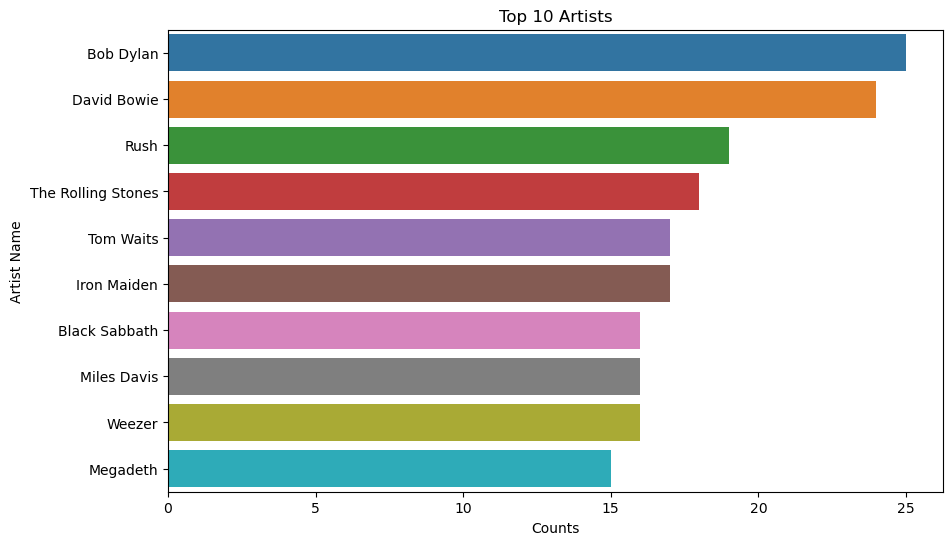

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='artist_name', order=df['artist_name'].value_counts()[:10].index)

plt.title('Top 10 Artists')
plt.xlabel('Counts')
plt.ylabel('Artist Name')

plt.show()

#### Genre

Below we include a bar plot displaying the counts of the top 10 most frequently occuring genres in the dataset. 

Before starting our analysis, we expected to see Pop as the top genre. We found that Singer-Songwriter is the most common genre in this dataset, with Alternative Rock close behind in second place. This somewhat lines up with our expectation, as many Singer-Songwriter artists are under the umbrella of Pop.

In [18]:
df['genres'] = df['genres'].str.split(", ")

In [19]:
all_genres = np.concatenate(df['genres'].values)

In [20]:
genres, genre_counts = np.unique(all_genres,return_counts=True)
genre_value_counts = dict(zip(genres, genre_counts))

In [21]:
sorted_genres = sorted(genre_value_counts.items(), key=lambda item: item[1], reverse=True)
dict(sorted_genres[:10])

{'Singer-Songwriter': 340,
 'Alternative Rock': 337,
 'Pop Rock': 283,
 'Indie Rock': 264,
 'Hard Rock': 203,
 'Art Pop': 198,
 'East Coast Hip Hop': 162,
 'Progressive Rock': 160,
 'Art Rock': 159,
 'Post-Punk': 154}

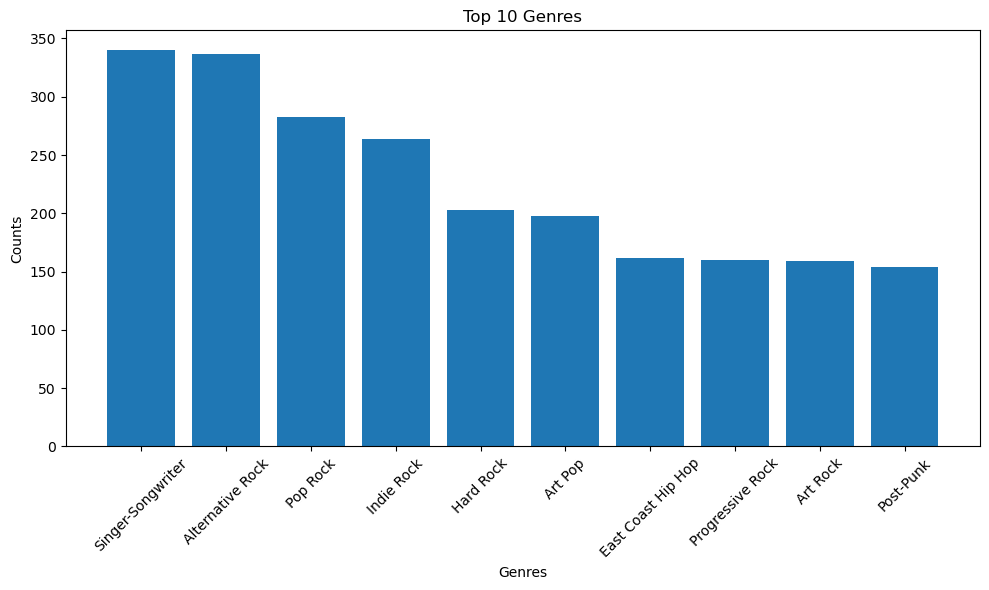

In [22]:
top_genres = dict(sorted_genres[:10])

categories = list(top_genres.keys())
values = list(top_genres.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values)

plt.title('Top 10 Genres')
plt.xlabel('Genres')
plt.ylabel('Counts')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Descriptors

In this dataset, `descriptors` refers to words assigned to albums that describe the musical body with respect to lyrical themes, melodic tendencies, tone, and overall emotional output. Below we include a bar plot of the counts of the top 10 most frequently occuring descriptors in our dataset.

We found that the descriptor 'malevocals' has by far the most occurences in this dataset.

In [23]:
df['descriptors'] = df['descriptors'].str.replace('.','').str.split(", ")

In [24]:
all_descriptors = np.concatenate(df['descriptors'].values)

In [25]:
all_descriptors = np.array([x.replace(',','') for x in all_descriptors])

In [26]:
descriptors, descriptor_counts = np.unique(all_descriptors,return_counts=True)
descriptor_value_counts = dict(zip(descriptors, descriptor_counts))

In [27]:
sorted_descriptors = sorted(descriptor_value_counts.items(), key=lambda item: item[1], reverse=True)
dict(sorted_descriptors[:10])

{'malevocals': 3541,
 'melodic': 2010,
 'energetic': 1661,
 'atmospheric': 1268,
 'rhythmic': 1218,
 'melancholic': 1206,
 'passionate': 1158,
 'bittersweet': 953,
 'playful': 899,
 'introspective': 885}

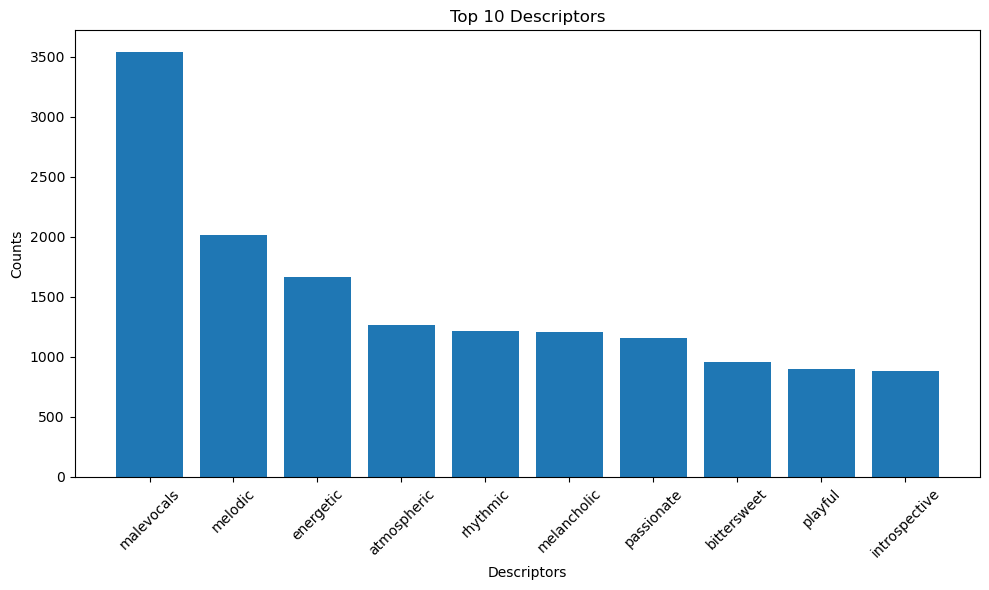

In [28]:
top_descriptors = dict(sorted_descriptors[:10])

categories = list(top_descriptors.keys())
values = list(top_descriptors.values())

plt.figure(figsize=(10, 6))
plt.bar(categories, values)

plt.title('Top 10 Descriptors')
plt.xlabel('Descriptors')
plt.ylabel('Counts')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Below, we plot the top 8 descriptors for each of the top 5 genres. It is interesting to see how each genre varies.

In [29]:
def plot_descriptors(genre_df, genre):
    descriptors_all = np.concatenate(genre_df['descriptors'].values)
    descriptors, descriptor_counts = np.unique(descriptors_all,return_counts=True)
    descriptor_value_counts = dict(zip(descriptors, descriptor_counts))
    sorted_descriptors = sorted(descriptor_value_counts.items(), key=lambda item: item[1], reverse=True)
    top_descriptors = dict(sorted_descriptors[:8])
    categories = list(top_descriptors.keys())
    values = list(top_descriptors.values())
    plt.figure(figsize=(6, 4))
    plt.bar(categories, values)
    title = ''.join(['Top 8 Descriptors for ', genre])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

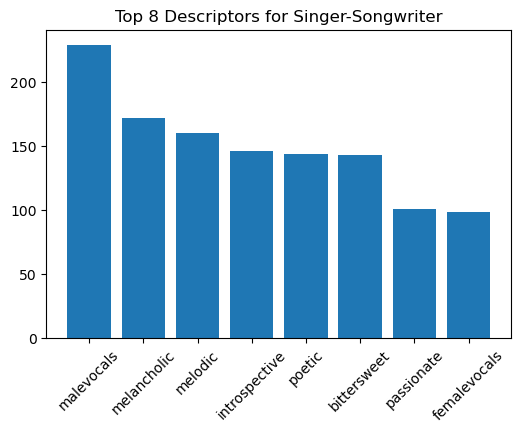

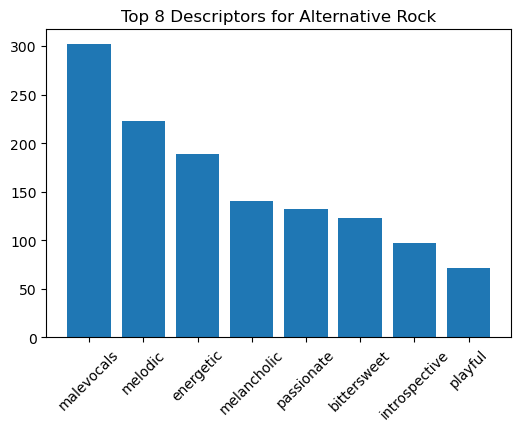

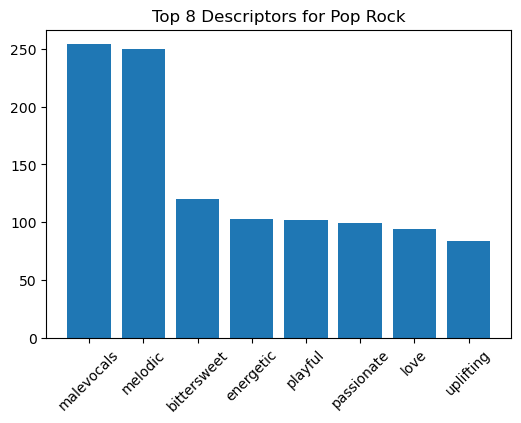

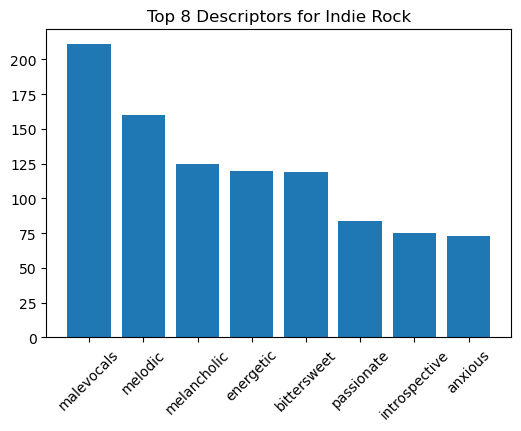

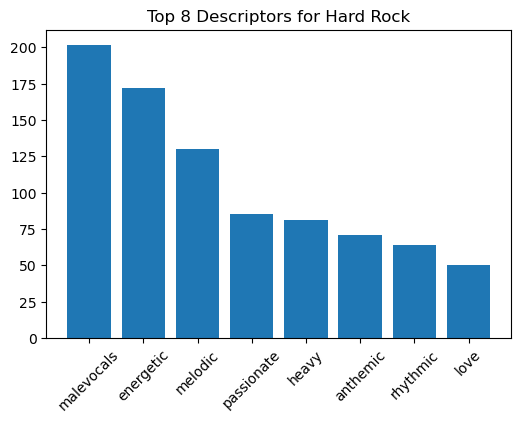

In [30]:
for genre in dict(sorted_genres[:5]) :
    index_list = []
    for i in range(4999) :
        if genre in df['genres'][i] :
            index_list.append(i)
    genre_df = df.iloc[index_list]
    plot_descriptors(genre_df, genre)

##### Gender of Vocalist

Of the descriptors in this dataset, two are of particular interest to us: `malevocals` and `femalevocals`. We use these descriptors to analyze the differences between albums with male vocals versus with female vocals in terms of musicality as well as societal reception. 

To make our analysis easier, we decided to create a new column in the dataframe called `vocals` and encode 0 to represent neither male nor female vocals, 1 to represent only male vocals, 2 to represent only female vocals, and 3 to represent both male and female vocals.

Before analyzing the data, we didn't have expectations about the musical differences between albums with male vocals and albums with female vocals. However, we did have expectations about the differences in terms of number of occurences in the dataset and societal reception. We expected that ‘malevocals’ would be overrepresented and that ‘malevocals’ will correlate with higher average ratings, as a result of societal prejudice. 

We found that the dataset indeed has much more albums with 'malevocals' than 'femalevocals'. In fact, there are more albums with no vocals at all than albums with 'femalevocals'. Later in our project, we do more comparitive analysis using our quantitative variables, such as `avg_rating`.

In [31]:
descriptor_dict = dict(sorted_descriptors)

In [32]:
for i in descriptor_value_counts.keys():
    if 'vocal' in i:
        print(i)

androgynousvocals
femalevocals
malevocals
vocalgroup


In [33]:
descriptor_dict['malevocals'], descriptor_dict['femalevocals']

(3541, 802)

In [34]:
# encoding: neither:0, male:1, female:2, both: 3
df['vocals'] = df['descriptors'].apply(lambda x: 1 if ('malevocals' in x and 'femalevocals' not in x) else (2 if ('femalevocals' in x and 'malevocals' not in x) else (3 if ('malevocals' in x and 'femalevocals' in x) else 0)))
df['vocals'].value_counts()

vocals
1    3346
0     852
2     607
3     194
Name: count, dtype: int64

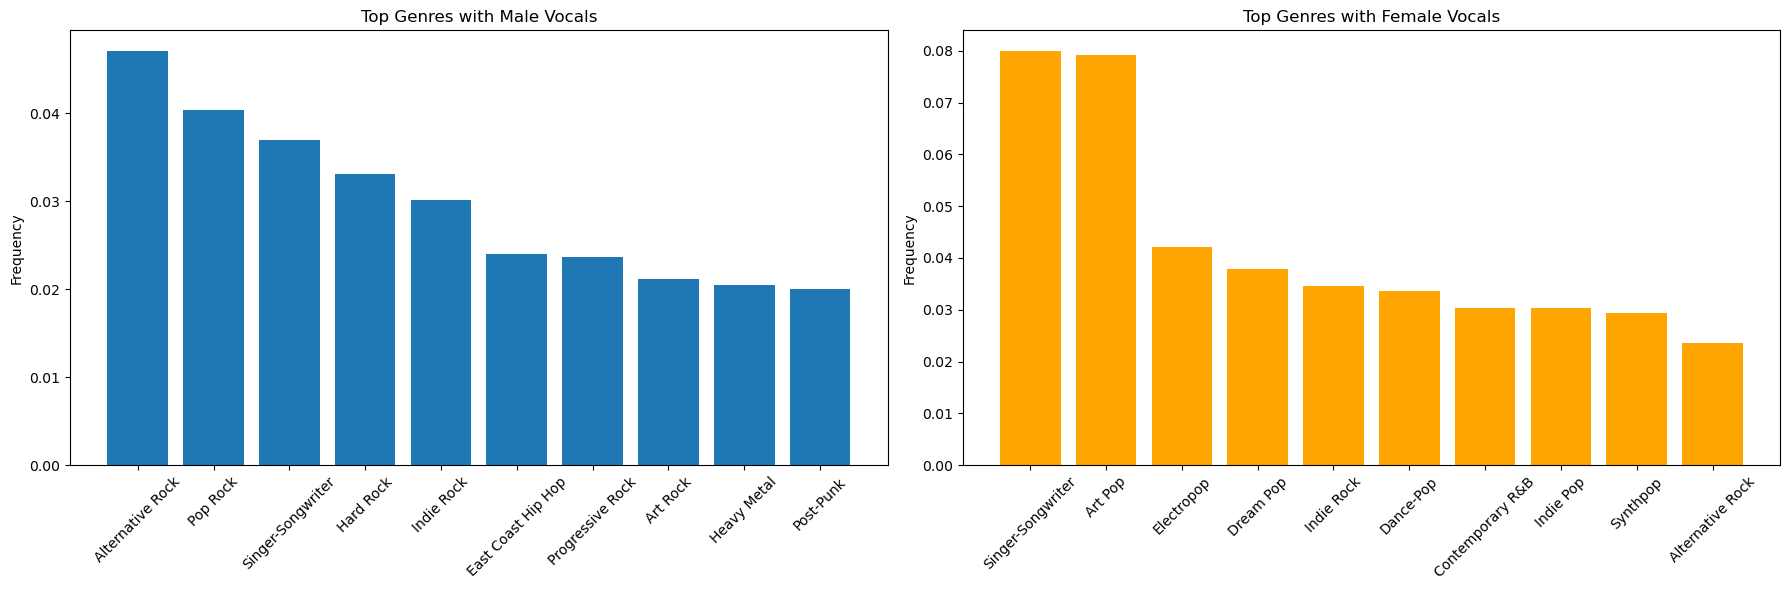

In [35]:
male_vocal_df = df[ df['vocals'] == 1]
m_all_genres = np.concatenate(male_vocal_df['genres'].values)
m_genres, m_genre_counts = np.unique(m_all_genres,return_counts=True)
total_genres_m = np.sum(m_genre_counts)
m_genre_value_counts = dict(zip(m_genres, m_genre_counts/total_genres_m))
m_sorted_genres = sorted(m_genre_value_counts.items(), key=lambda item: item[1], reverse=True)
m_top_genres = dict(m_sorted_genres[:10])


female_vocal_df = df[ df['vocals'] == 2]
f_all_genres = np.concatenate(female_vocal_df['genres'].values)
f_genres, f_genre_counts = np.unique(f_all_genres,return_counts=True)
total_genres_f = np.sum(f_genre_counts)
f_genre_value_counts = dict(zip(f_genres, f_genre_counts/total_genres_f))
f_sorted_genres = sorted(f_genre_value_counts.items(), key=lambda item: item[1], reverse=True)
f_top_genres = dict(f_sorted_genres[:10])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

axes[0].bar(list(m_top_genres.keys()), list(m_top_genres.values()))
axes[0].set_title('Top Genres with Male Vocals')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(list(m_top_genres.keys()), rotation=45)

axes[1].bar(list(f_top_genres.keys()), list(f_top_genres.values()), color='orange')
axes[1].set_title('Top Genres with Female Vocals')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(list(f_top_genres.keys()), rotation=45)

plt.tight_layout()
plt.show()

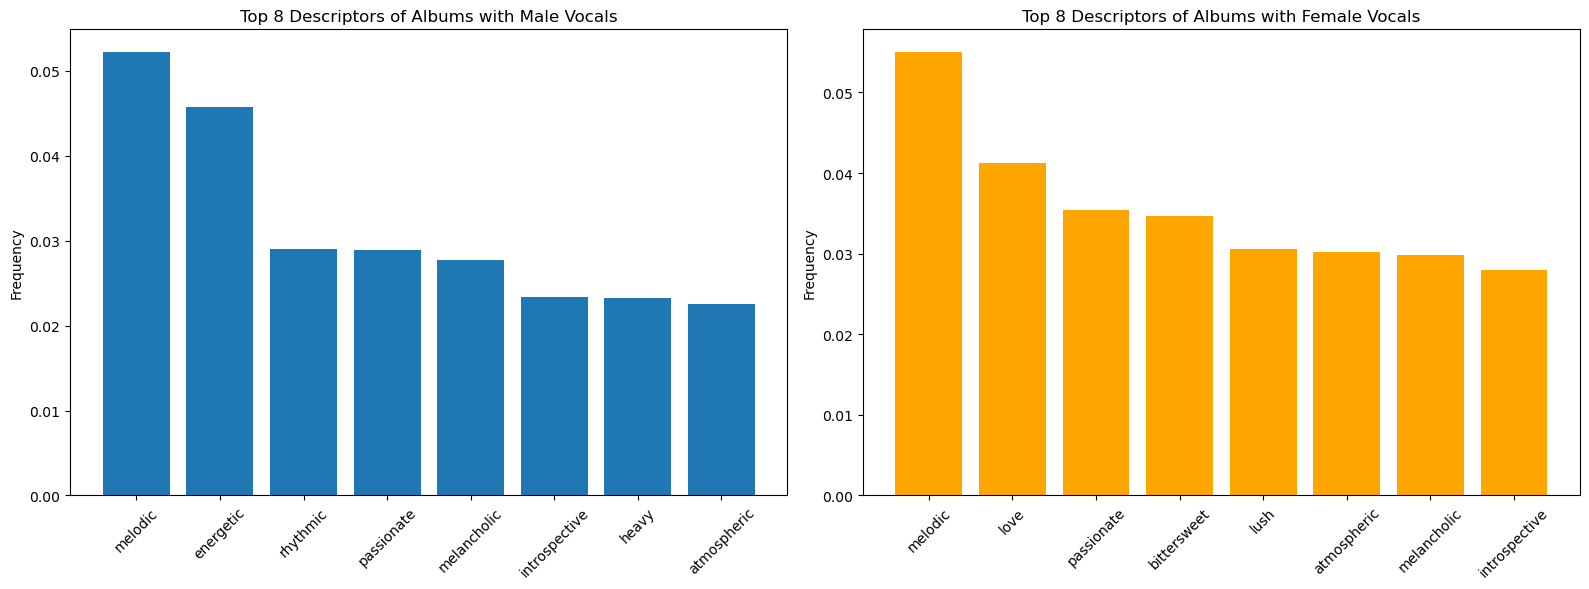

In [36]:
m_all_descriptors = np.concatenate(male_vocal_df['descriptors'].values)
m_all_descriptors = np.delete(m_all_descriptors, np.where(m_all_descriptors=='malevocals'))
m_all_descriptors = np.delete(m_all_descriptors, np.where(m_all_descriptors=='femalevocals'))
m_descriptors, m_descriptor_counts = np.unique(m_all_descriptors,return_counts=True)
total_m = np.sum(m_descriptor_counts)
m_descriptor_value_counts = dict(zip(m_descriptors, m_descriptor_counts/total_m))
m_sorted_descriptors = sorted(m_descriptor_value_counts.items(), key=lambda item: item[1], reverse=True)
m_top_descriptors = dict(m_sorted_descriptors[:8])

f_all_descriptors = np.concatenate(female_vocal_df['descriptors'].values)
f_all_descriptors = np.delete(f_all_descriptors, np.where(f_all_descriptors=='malevocals'))
f_all_descriptors = np.delete(f_all_descriptors, np.where(f_all_descriptors=='femalevocals'))
f_descriptors, f_descriptor_counts = np.unique(f_all_descriptors,return_counts=True)
total_f = np.sum(f_descriptor_counts)
f_descriptor_value_counts = dict(zip(f_descriptors, f_descriptor_counts/total_f))
f_sorted_descriptors = sorted(f_descriptor_value_counts.items(), key=lambda item: item[1], reverse=True)
f_top_descriptors = dict(f_sorted_descriptors[:8])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].bar(list(m_top_descriptors.keys()), list(m_top_descriptors.values()))
axes[0].set_ylabel('Frequency')
axes[0].set_title('Top 8 Descriptors of Albums with Male Vocals')
axes[0].set_xticklabels(list(m_top_descriptors.keys()), rotation=45)

axes[1].bar(list(f_top_descriptors.keys()), list(f_top_descriptors.values()), color='orange')
axes[1].set_title('Top 8 Descriptors of Albums with Female Vocals')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(list(f_top_descriptors.keys()), rotation=45)

plt.tight_layout()
plt.show()

#### Release Year (`year`)

Below we include a plot describing the number of albums released each year in our dataset.

Before analyzing the data, we expected that release dates will range from the 1960’s to the 2020’s, with a skew towards the more recent decades. This is somewhat similar to our findings. We found that the recent decades indeed have more entries in this dataset, and there are many peaks and valleys in our plot of release years vs. number of observances.

In [37]:
year_counts = df['year'].value_counts()
year_counts[:10]

year
2018    150
2020    145
2019    144
2017    140
2005    128
2013    125
2015    121
2021    120
2011    119
2006    119
Name: count, dtype: int64

In [38]:
year_counts_time = year_counts.sort_index()

By plotting the count of albums per year, we observe a general increasing trend in the number of albums produced and rated, particularly notable from the 1960s onwards. This rise could be attributed to several factors, including technological advancements such as the development of the internet, which has made music more accessible globally and has allowed more albums to be distributed and rated by a broader audience. 

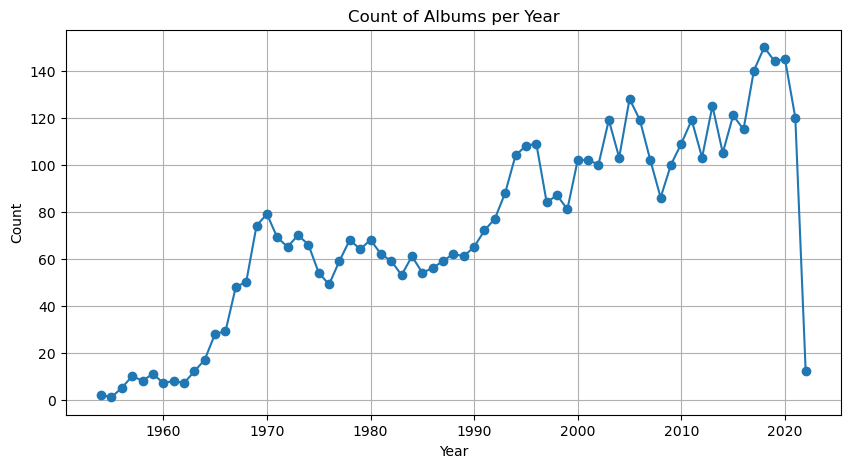

In [39]:
plt.figure(figsize=(10, 5))  
plt.plot(year_counts_time.index, year_counts_time.values, marker='o')  

plt.title('Count of Albums per Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.grid(True)  
plt.show()

The below graph illustrates the annual count of albums categorized by vocal type—male and female—from the 1960s through 2020. It highlights notable trends in the music industry over several decades. Albums featuring male vocals have historically outnumbered those with female vocals, although the gap has narrowed significantly since the 2000s.

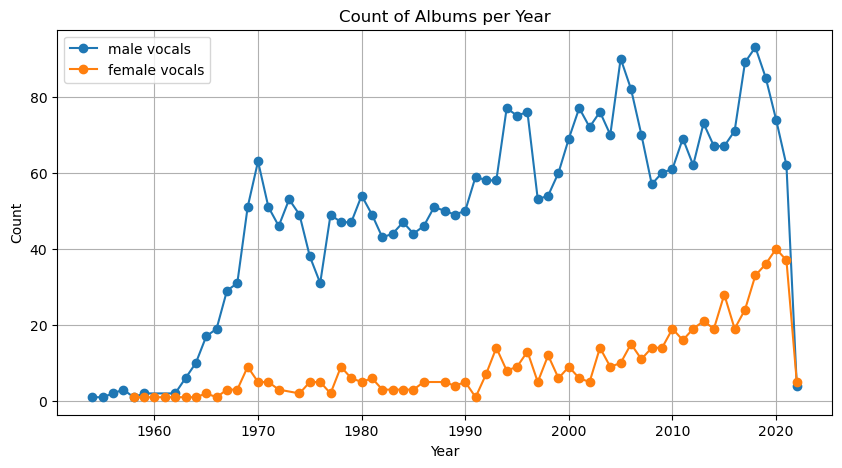

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(male_vocal_df.year.value_counts().sort_index().index, male_vocal_df.year.value_counts().sort_index().values, marker='o', label='male vocals')
plt.plot(female_vocal_df.year.value_counts().sort_index().index, female_vocal_df.year.value_counts().sort_index().values, marker='o', label='female vocals')

plt.title('Count of Albums per Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()

plt.grid(True)  
plt.show()

-----

### Numerical Variables

#### Average Rating

Below we found the measurements of central tendency and extremum values for our variable `avg_rating` which refers to the average rating for each album in the dataset.

Before starting our analysis, we expected that the average ratings would be distributed from 0 to 5 with a skew towards the right, since people are more likely to review albums that they like. This is in line with our findings. We found that the average ratings in our dataset span from 0.62 to 4.34 with a mean of 3.54 and a median of 3.62.

In [41]:
df.columns

Index(['position', 'release_name', 'artist_name', 'year', 'genres',
       'descriptors', 'avg_rating', 'rating_count', 'review_count', 'vocals'],
      dtype='object')

In [42]:
print("Mean rating: " + str(round(df['avg_rating'].mean(),2)))
print("Median rating: " + str(round(df['avg_rating'].median(),2)))
print("Maximum rating: " + str(round(df['avg_rating'].max(),2)))
print("Minimumm rating: " + str(round(df['avg_rating'].min(),2)))

Mean rating: 3.54
Median rating: 3.62
Maximum rating: 4.34
Minimumm rating: 0.62


Below we take a look at the distribution of ratings. It is skewed to left, with a median of 3.62. We've also plotted the 25th, 50th (median) and 75th percentile on the plot.

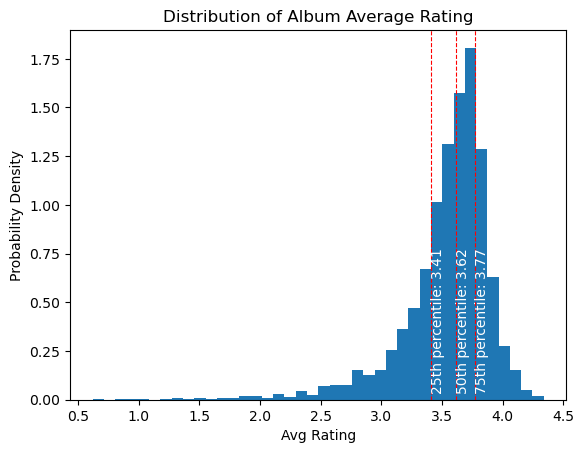

In [43]:
# Rating distribution
plt.hist(df['avg_rating'], bins=40, density=True)
plt.title('Distribution of Album Average Rating')
plt.xlabel('Avg Rating')
plt.ylabel('Probability Density')

percentiles = [25, 50, 75]
percentile_values = np.percentile(df['avg_rating'], percentiles)

for i, percentile in enumerate(percentiles):
    plt.axvline(percentile_values[i], color='r', linestyle='--', linewidth=0.8)
    plt.text(percentile_values[i], 0.03, f'{percentile}th percentile: {percentile_values[i]:.2f}', rotation=90, verticalalignment='bottom', color='white')

plt.show()

#### Avg Rating by Year

Below, we analyze and plot the trend of the average ratings for each release year.

Interestingly, we found that earlier release years tend to have higher ratings. We believe that people may feel nostalgic towards older albums, contributing to the trend that we see.

In [44]:
rating_by_year = df.groupby('year')['avg_rating'].mean()

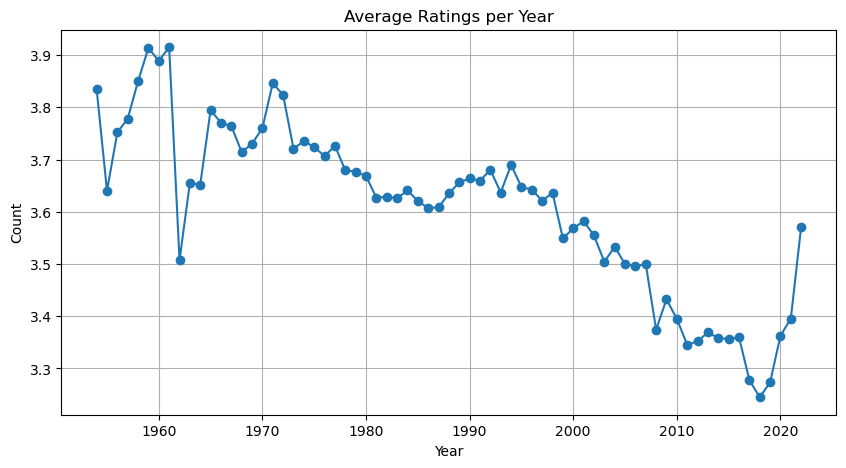

In [45]:
plt.figure(figsize=(10, 5))  
plt.plot(rating_by_year.index, rating_by_year.values, marker='o')  

plt.title('Average Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.grid(True)  
plt.show()

#### Avg Rating by Genre

In [46]:
genre_rating_dict = {}
for genre in np.unique(all_genres):
    index_list = []
    for i in range(4999) :
        if genre in df['genres'][i] :
            index_list.append(i)
    genre_df = df.iloc[index_list]
    avg_rating = genre_df.avg_rating.mean()
    genre_rating_dict[genre] = avg_rating
    sorted_genre_rating = sorted(genre_rating_dict.items(), key=lambda item: item[1], reverse=True)

top_rated_genres = dict(sorted_genre_rating[:10])
lowest_rated_genres = dict(sorted_genre_rating[-10:])

Below we listed the top 10 rated genres and their average ratings.

In [47]:
top_rated_genres_rounded = {genre: round(rating, 2) for genre, rating in top_rated_genres.items()}
top_rated_genres_rounded

{'Picopop': 4.02,
 'Romanticism': 4.02,
 'Orchestral': 4.01,
 'Samba Soul': 4.01,
 'Video Game Music': 4.0,
 'Television Music': 4.0,
 'Dance': 4.0,
 'Samba-rock': 3.99,
 'Lounge': 3.98,
 'Afrobeat': 3.97}

#### Review count & Rating count

Below we look at the variables `review_count` and `rating_count` which represent the number of reviews and ratings each album has, respectively. Both distributions are skewed to right. Reviews are written descriptive evaluations of the album, and ratings are numerical assessments from 0 to 5.

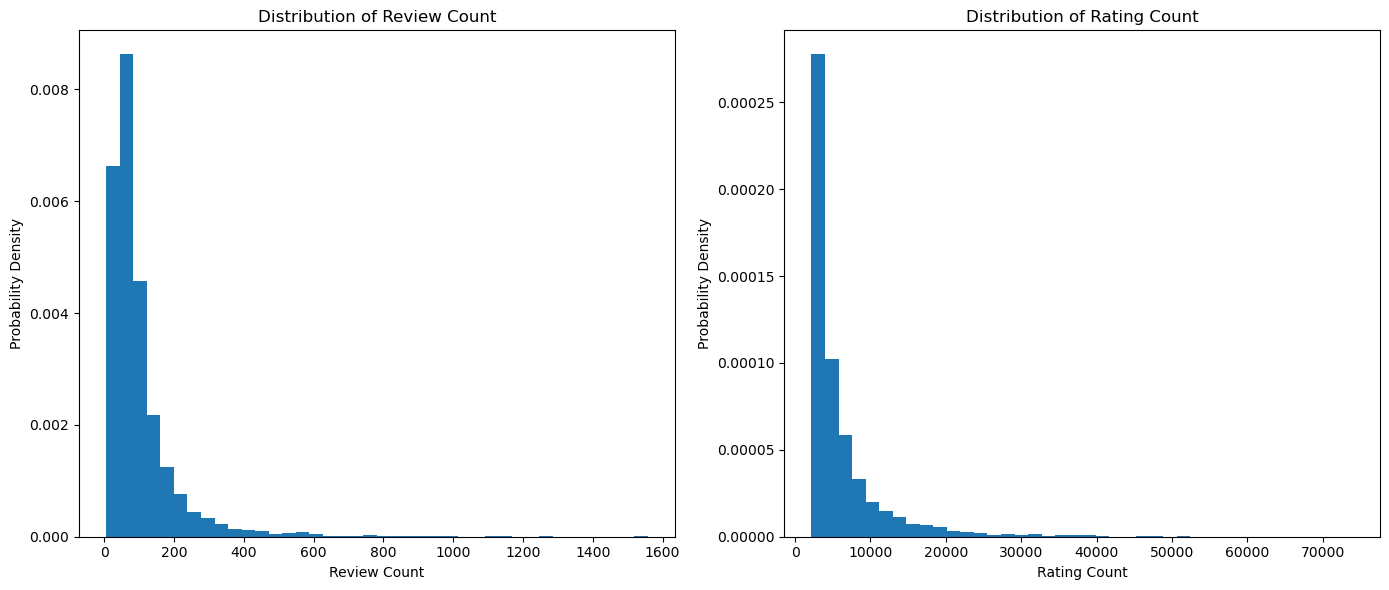

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

axes[0].hist(df['review_count'], bins=40, density=True)  
axes[0].set_title('Distribution of Review Count')
axes[0].set_ylabel('Probability Density')
axes[0].set_xlabel('Review Count')

axes[1].hist(df['rating_count'], bins=40, density=True)  
axes[1].set_title('Distribution of Rating Count')
axes[1].set_ylabel('Probability Density')
axes[1].set_xlabel('Rating Count')

plt.tight_layout()
plt.show()

We found that there appears to be a positive correlation between review count and rating count. Albums with more ratings tend to have more reviews.

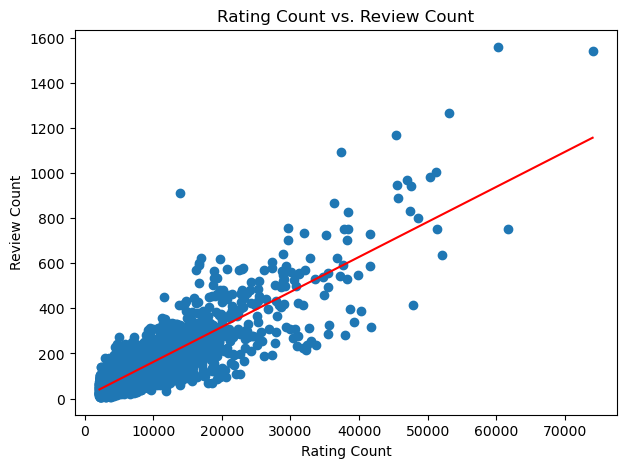

In [49]:
X = df['rating_count']
y = df['review_count']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

plt.figure(figsize=(7,5))
plt.scatter(df['rating_count'], df['review_count'], label='Data')
plt.plot(df['rating_count'], predictions, color='red', label='OLS Regression Line')

plt.title('Rating Count vs. Review Count')
plt.xlabel('Rating Count')
plt.ylabel('Review Count')

plt.show()

<br><br>

## Sentimental Analysis

In [50]:
# !pip3 install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alish\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The first step for this process would be to determine the sentiment of the descriptors and genres of each album using the VADER library. This will allow us to get a compound score for the sentiment of an album in which we can use to answer the question: How does an album's sentiment affect it's populatrity and what types of albums are more popular over the years?

We first begin by cleaning the data in our `genres` and `descriptors` columns so that we can be able to conduct proper analysis for our album sentiments. 

In [51]:
sid = SentimentIntensityAnalyzer()
sentiment_df = df
for col in ['genres', 'descriptors']:
    sentiment_df[col] = sentiment_df[col].apply(lambda x: ' '.join(x))
    sentiment_df[col] = sentiment_df[col].apply(lambda x: x.lower())

The next step we have to take is to generate our polarity scores with a specific focus on the compound scores for both columns. This is accomplished within our Sentiment Intensity Analyzer, more specifically through the `polarity_scores` function, in which the compound score is a normalization of the positive, negative, and neutral scores assigned by the analyzer.

In [52]:
for col in ['genres', 'descriptors']:
    sentiment_df['{}_sentiment'.format(col)] = sentiment_df[col].apply(lambda x: sid.polarity_scores(x)['compound'])
sentiment_df.head()

,position,release_name,artist_name,year,genres,descriptors,avg_rating,rating_count,review_count,vocals,genres_sentiment,descriptors_sentiment
0,1,OK Computer,Radiohead,1997,alternative rock art rock,melancholic anxious futuristic malevocals exis...,4.24,74027,1541,1,0.0,-0.8126
1,2,Kid A,Radiohead,2000,art rock experimental rock electronic,cold melancholic futuristic anxious atmospheri...,4.23,61658,751,1,0.0,-0.3182
2,3,The Dark Side of the Moon,Pink Floyd,1973,art rock progressive rock,philosophical atmospheric introspective existe...,4.21,60192,1557,1,0.0,0.0000
3,4,Loveless,My Bloody Valentine,1991,shoegaze noise pop,noisy ethereal atmospheric romantic love dense...,4.24,53174,1264,2,0.0,0.7351
4,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010,pop rap hip hop,epic boastful passionate sampling hedonistic v...,4.09,52149,638,1,0.0,0.5267


Because compound scores range from -1 to 1 and we have 4999 entries we are focusing on for this dataset, being able to visualize such a large and diverse set of datapoints will be important for our analysis. We will accomplish this objective through the use of the hexbins feature in our `plt` library. Since we are conducting sentiment analysis on two different categories of our albums, we will display plots for both our `descriptors` and `genres`. 

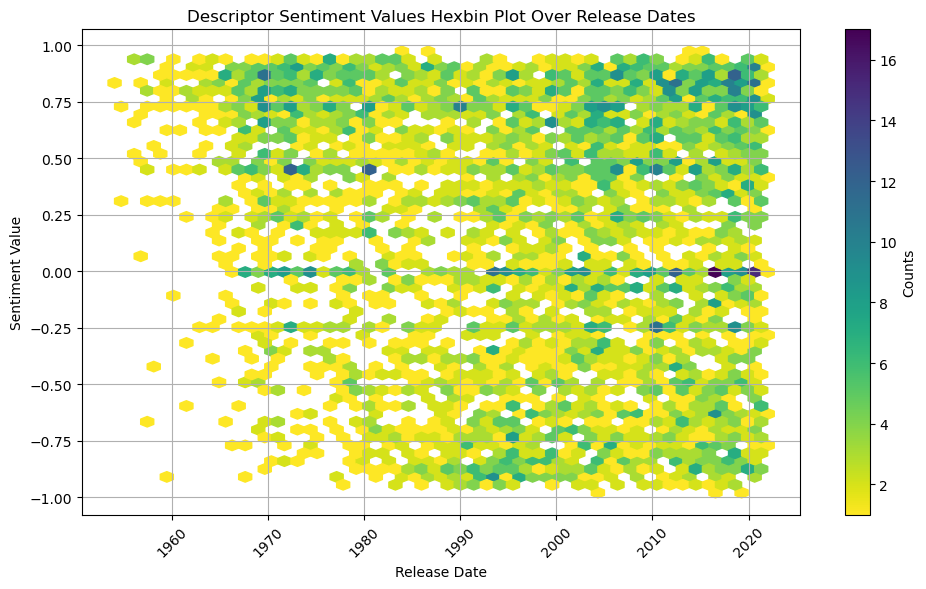

In [53]:
plt.figure(figsize=(10, 6))
hb = plt.hexbin(sentiment_df['year'], sentiment_df['descriptors_sentiment'], gridsize=50, cmap='viridis_r', mincnt=1)

plt.colorbar(hb, label='Counts')
plt.title('Descriptor Sentiment Values Hexbin Plot Over Release Dates')
plt.xlabel('Release Date')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

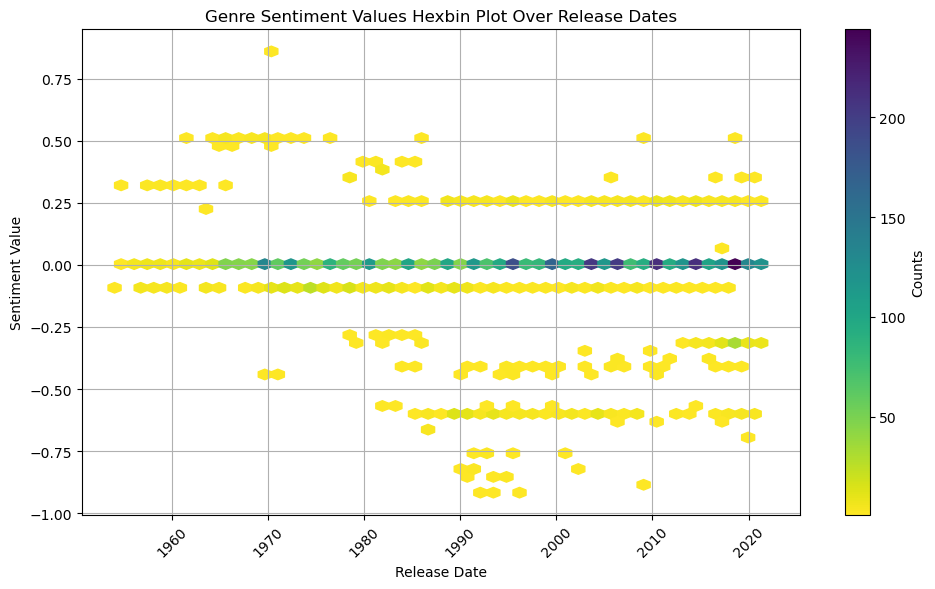

In [54]:
plt.figure(figsize=(10, 6))
hb = plt.hexbin(sentiment_df['year'], sentiment_df['genres_sentiment'], gridsize=50, cmap='viridis_r', mincnt=1)

plt.colorbar(hb, label='Counts')
plt.title('Genre Sentiment Values Hexbin Plot Over Release Dates')
plt.xlabel('Release Date')
plt.ylabel('Sentiment Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

It is clear to see that our Sentiment Intensity Analyzer was able to assign a more diverse set of values to our albums' descriptors compared to our albums' genres. We see a very concentrated amount of albums who possess a sentiment value score of 0. There are many possibilties for why this was the case but a few that we could think of were that some of the strings present in the `genres` column weren't long enough for the analyzer to create a proper compound score or there was a chance that the normalization of the polarity scores made the compound score equal to 0.

As a result, we'll move forward with our Sentiment Analysis only focusing on the compound scores for our descriptors in our `descriptors_sentiment` column. Let's now take a look at the distribution our data takes on in terms of the various albums' sentiment values.

<Axes: title={'center': 'Distribution of Descriptors Sentiment'}, xlabel='Sentiment Value', ylabel='Amount of Albums'>

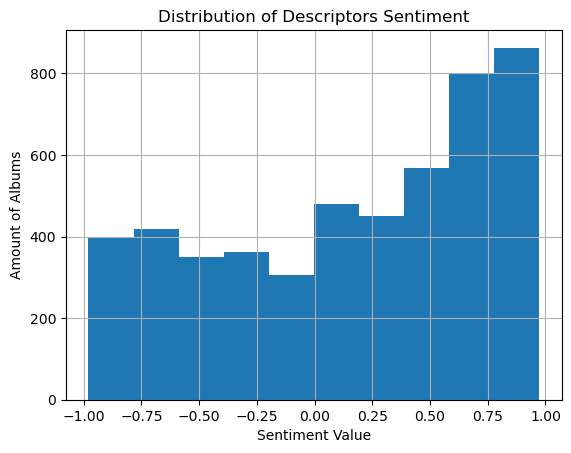

In [55]:
sentiment_distribution = sentiment_df['descriptors_sentiment'].hist()
sentiment_distribution.set_title('Distribution of Descriptors Sentiment')
sentiment_distribution.set_xlabel('Sentiment Value')
sentiment_distribution.set_ylabel('Amount of Albums')
sentiment_distribution

We can notice a nonuniform distribution of the sentiment across the albums we are studying in our dataset. The sentiment distribution of album descriptors appears relatively consistent across most sentiment values, with a noticeable increase in the number of albums exhibiting positive sentiment values around 0. This sudden increase suggests a shift towards more positive sentiment expressions for a significant portion of the albums in our dataset.

Let's now take a look at the average sentiments by year for our album descriptors:

In [56]:
sentiment_df.groupby('year')[['descriptors_sentiment']].mean()

,descriptors_sentiment
year,
1954,0.768000
1955,0.296000
1956,0.803980
1957,0.682010
1958,0.357038
...,...
2018,0.118668
2019,0.170474
2020,0.143473


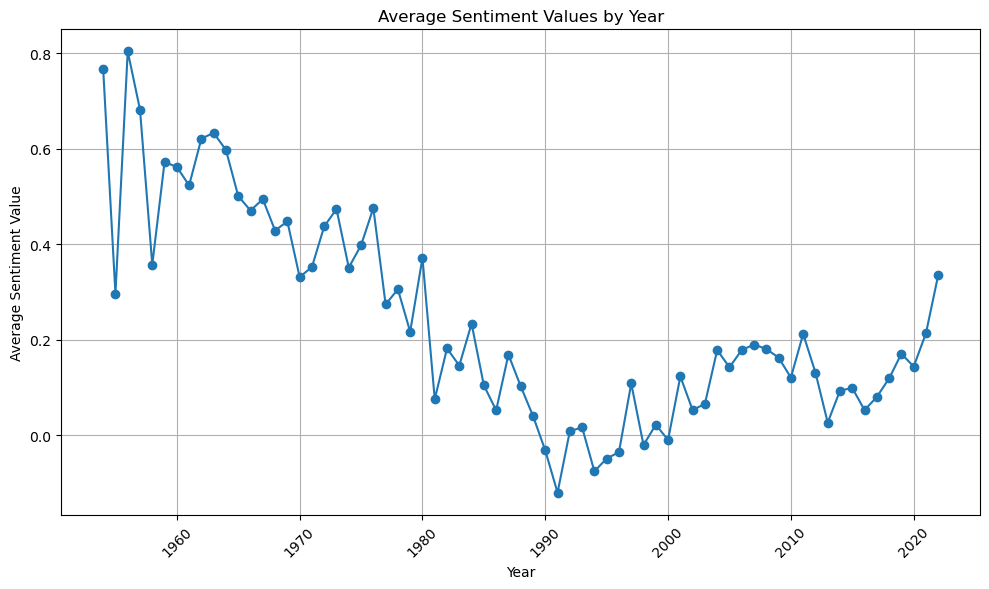

In [57]:
average_sentiment_by_year = sentiment_df.groupby(sentiment_df['year'])['descriptors_sentiment'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_year.index, average_sentiment_by_year.values, marker='o', linestyle='-')
plt.title('Average Sentiment Values by Year')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

It's important to note that some of these years may have a proportionally larger average sentiment compared to the rest of the years because of the limited number of inclusions of albums rated from those specific years. Let's take a look at which years have less than 1% of the total number of albums being studied in this analysis. 

In [58]:
sentiment_df['year'].value_counts()[sentiment_df['year'].value_counts() < 50]

year
1976    49
1967    48
1966    29
1965    28
1964    17
1963    12
2022    12
1959    11
1957    10
1958     8
1961     8
1960     7
1962     7
1956     5
1954     2
1955     1
Name: count, dtype: int64

Several years have less than 1% of the total number of albums reviewed in our dataset so we will disregard them in our updated graph to depict a more filtered set of points.

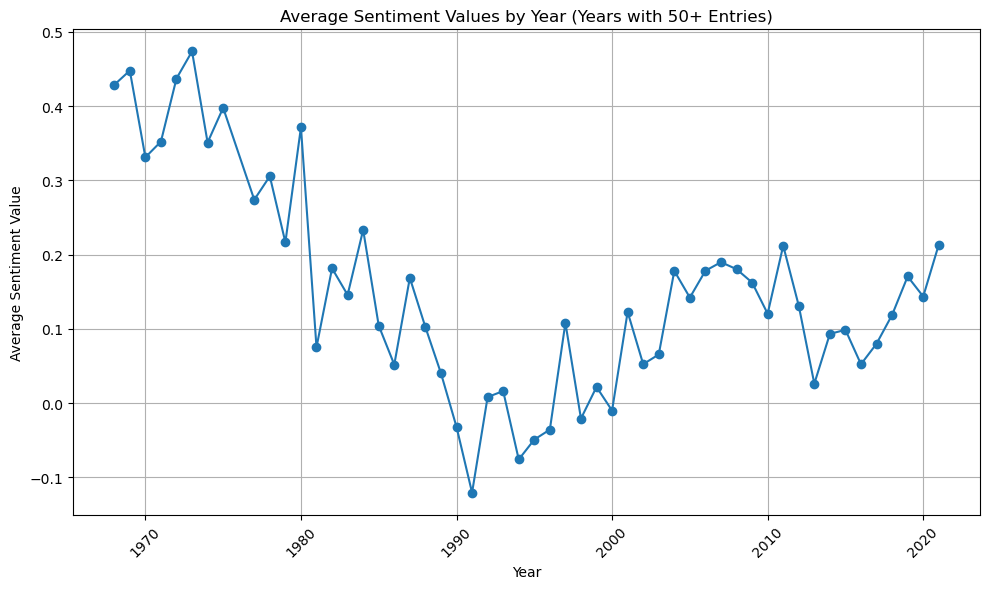

In [59]:
years_with_50_plus_entries = sentiment_df['year'].value_counts()[sentiment_df['year'].value_counts() >= 50].index

filtered_df = sentiment_df[sentiment_df['year'].isin(years_with_50_plus_entries)]

average_sentiment_by_year = filtered_df.groupby(filtered_df['year'])['descriptors_sentiment'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_sentiment_by_year.index, average_sentiment_by_year.values, marker='o', linestyle='-')
plt.title('Average Sentiment Values by Year (Years with 50+ Entries)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

As we can see, there is a significant downward trend in the average sentiment value of albums with the lowest being in the year 1991 and then an upward trend there after. There is a possibility we can contribute these factors to the popularity of genres across these certain periods of time. Genres like jazz and funk were known to be the most popular during the 70s for their uplifing/positive beats and lyrics, while the 90s had a rise in the poularity of alternative rock and rap which consisted of more rough/boastful sounds which are often related to a more negative sentiment. 

Let's proceed with depicting our range of points with an emphasis on the albums' sentiment ratings vs. their average ratings. This will give us a better idea of the type of distribution our points take on and view any possible outliers we may need to take a note of for our future analysis. 

<Axes: title={'center': 'Descriptor Sentiment vs. Average Rating'}, xlabel='Sentiment Value', ylabel='Average Rating'>

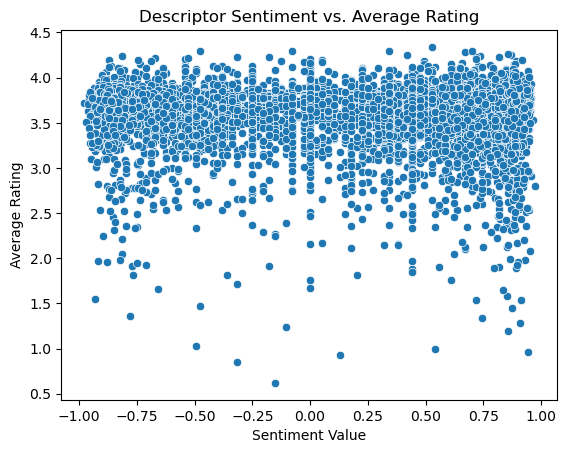

In [60]:
sent_scatter = sns.scatterplot(y = 'avg_rating', x = 'descriptors_sentiment', data = sentiment_df)
sent_scatter.set_xlabel('Sentiment Value')
sent_scatter.set_ylabel('Average Rating')
sent_scatter.set_title('Descriptor Sentiment vs. Average Rating')
sent_scatter

As we can see, a lot of the albums we are focusing on in our dataset have a relatively high average rating (around the 3.5 mark) with various ranges in their sentiment value. We can also see that there are a couple of albums which have relatively low average ratings as well. We'll make a note of all these details now to consider for analysis in our future tests.

<br><br>

## Statistical Analysis and Inference

### Question 1: Is there a difference in the means of the ratings for albums with male vocals and albums with female vocals?

Let $M_1, M_2, ... , M_{n}$ represent the ratings of albums with male vocals. Let $F_1, F_2, ... , F_{p}$ represent the ratings of albums with female vocals. Let $\mu_M$ represent the mean of the ratings of albums with male vocals and let $\mu_F$ represent the mean of the ratings of albums with female vocals. We test
$$
H_0: \mu_M = \mu_F \quad \text{vs} \quad H_a: \mu_M \neq \mu_F
$$

We will carry out this hyothesis test with a 5% significance level.

First, let's look at our data:

In [61]:
male_avg = male_vocal_df.avg_rating.mean()
female_avg = female_vocal_df.avg_rating.mean()

print('Mean avg_rating of albums with male vocals: ', male_avg)
print('Mean avg_rating of albums with female vocals: ', female_avg)

Mean avg_rating of albums with male vocals:  3.515511057979677
Mean avg_rating of albums with female vocals:  3.5099670510708405


<br>

| Anatomy of the hypothesis test |                                                               |
|:------------------------------:|:--------:|
| Assumption                     | $$M_1, ... , M_{n} \sim N(\mu_M, \sigma_M^2)$$ and $$F_1, ... , F_{p} \sim N(\mu_F, \sigma_F^2)$$ |
| Population parameter           | $$\theta = \mu_M - \mu_F$$ |
| Sample statistic               | $$\hat\theta = \overline{M} - \overline{F}$$ |
| Test statistic                 | $$T = \displaystyle\frac{\hat\theta - \theta}{\text{SE}} \sim t_{k}$$ |
| Null hypothesis                | $$H_0: \theta = 0$$ |
| Alternate hypothesis           | $$H_a: \theta \neq 0$$ |
| Rejection region shape         | $$(-\infty, -x_\alpha) \cup (x_\alpha, \infty)$$ |

Now let's run the test:

In [62]:
alpha = 0.05

T, pvalue = stats.ttest_ind(
    male_vocal_df.avg_rating, 
    female_vocal_df.avg_rating, 
    equal_var=False,
    alternative='two-sided'
)

if pvalue < alpha:
    print('Reject H0: p-value = ', pvalue, ' < ', alpha, ' = alpha')
else:
    print('Fail to reject H0: p-value = ', pvalue, ' > ', alpha, ' = alpha')

Fail to reject H0: p-value =  0.6963101831213759  >  0.05  = alpha


Therefore, we conclude that is seems there is no difference in the means of ratings of albums with male vocals and albums with female vocals.

<br>

### Question 2: Are the distributions of the ratings of albums with male vocals and the ratings of albums with female vocals the same?

To answer this, we will execture a two-sample Kolmogorov-Smirnov Test.

Suppose $M_1, M_2, ..., M_n \sim \mathcal{F}_M$ and $F_1, F_2, ..., F_p \sim \mathcal{F}_F$. We test
$$
H_0: \mathcal{F}_M = \mathcal{F}_F \quad \text{vs} \quad H_a: \mathcal{F}_M \neq \mathcal{F}_F
$$
We will carry out this hyothesis test with a 5% significance level.

First, let's look at our data:

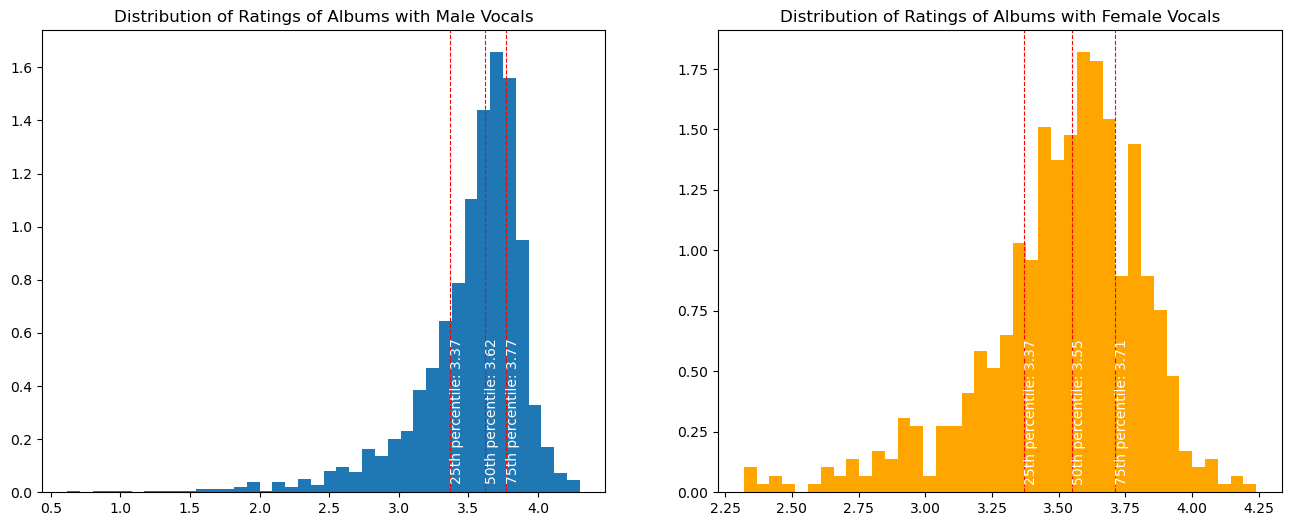

In [63]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))
axes[0].hist(male_vocal_df.avg_rating, bins=40, density=True)
axes[0].set_title('Distribution of Ratings of Albums with Male Vocals')
axes[1].hist(female_vocal_df.avg_rating, bins=40, density=True, color='orange')
axes[1].set_title('Distribution of Ratings of Albums with Female Vocals')

percentiles = [25, 50, 75]
male_percentile_values = np.percentile(male_vocal_df.avg_rating, percentiles)
female_percentile_values = np.percentile(female_vocal_df.avg_rating, percentiles)

for i, percentile in enumerate(percentiles):
    axes[0].axvline(male_percentile_values[i], color='r', linestyle='--', linewidth=0.8)
    axes[0].text(male_percentile_values[i], 0.03, f'{percentile}th percentile: {male_percentile_values[i]:.2f}', rotation=90, verticalalignment='bottom', color='white')
    axes[1].axvline(female_percentile_values[i], color='r', linestyle='--', linewidth=0.8)
    axes[1].text(female_percentile_values[i], 0.03, f'{percentile}th percentile: {female_percentile_values[i]:.2f}', rotation=90, verticalalignment='bottom', color='white')
plt.show()

<br>

| Anatomy of the hypothesis test |    |
|:------------------------------:|:--------:|
| Assumption                     | $M_1, ... , M_{n} \sim \mathcal{F}_M$ and $F_1, ... , F_{p} \sim \mathcal{F}_F$|
| Null hypothesis                | $H_0: \mathcal{F}_M = \mathcal{F}_F$ |
| Alternate hypothesis           | $H_a: \mathcal{F}_M \neq \mathcal{F}_F$  |
| Test statistic                 | $D_{n,p} = \sup_{x} \Big\| \hat{\mathcal{F}}_n(x) - \hat{\mathcal{F}}_p(x) \Big\|$ |
| Rejection region shape         | $(x_\alpha , \infty)$ |

Now, let's run our test:

In [64]:
alpha = 0.05

KS_result = stats.kstest(male_vocal_df.avg_rating, female_vocal_df.avg_rating)

pvalue = KS_result.pvalue

if pvalue < alpha:
    print('Reject H0: p-value = ', round(pvalue,5), ' < ', alpha, ' = alpha')
else:
    print('Fail to reject H0: p-value = ', pvalue, ' > ', alpha, ' = alpha')

Reject H0: p-value =  1e-05  <  0.05  = alpha


Therefore, we conclude that there is statistically significant evidence suggesting the distributions of ratings of albums with male vocals and ratings of albums with female vocals are not the same.

### Question 3: Is the distribution of sentiment value of the descriptors of albums with male vocals and albums with female vocals the same?

Let $X_1, X_2, ... , X_{n}$ represent the sentiment values of the descriptors of albums with male vocals. Let $Y_1, Y_2, ... , Y_{m}$ represent the sentiment values of the descriptors of albums with male vocals. Suppose $X_1, X_2, ... , X_{n} \sim \mathcal{F}_X$ and $Y_1, Y_2, ... , Y_{m} \sim \mathcal{F}_Y$. We test
$$
H_0: \mathcal{F}_X = \mathcal{F}_Y \quad \text{vs} \quad H_a: \mathcal{F}_X \neq \mathcal{F}_Y 
$$

We will carry out this hyothesis test with a 5% significance level.

First, let's look at our data:

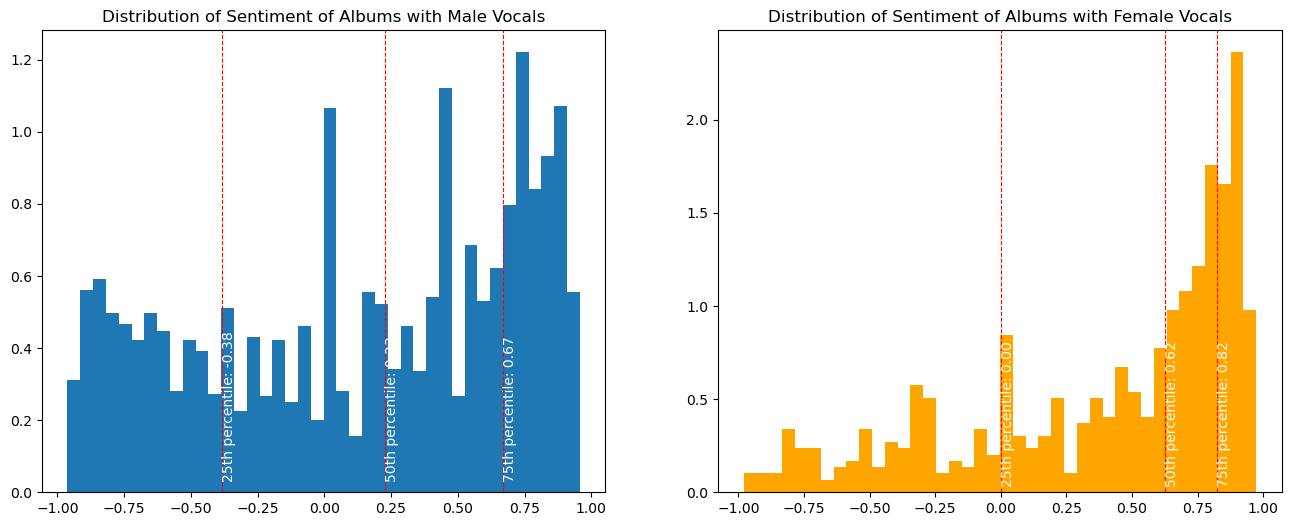

Mean sentiment value of albums with male vocals:  0.13259354453078304
Mean sentiment value of albums with female vocals:  0.399343492586491


In [65]:
fig, axes = plt.subplots(1,2, figsize=(16, 6))
axes[0].hist(sentiment_df[ sentiment_df['vocals'] == 1 ]['descriptors_sentiment'], bins=40, density=True)
axes[0].set_title('Distribution of Sentiment of Albums with Male Vocals')
axes[1].hist(sentiment_df[ sentiment_df['vocals'] == 2 ]['descriptors_sentiment'], bins=40, density=True, color='orange')
axes[1].set_title('Distribution of Sentiment of Albums with Female Vocals')

percentiles = [25, 50, 75]
male_percentile_values = np.percentile(sentiment_df[ sentiment_df['vocals'] == 1 ]['descriptors_sentiment'], percentiles)
female_percentile_values = np.percentile(sentiment_df[ sentiment_df['vocals'] == 2 ]['descriptors_sentiment'], percentiles)

for i, percentile in enumerate(percentiles):
    axes[0].axvline(male_percentile_values[i], color='r', linestyle='--', linewidth=0.8)
    axes[0].text(male_percentile_values[i], 0.03, f'{percentile}th percentile: {male_percentile_values[i]:.2f}', rotation=90, verticalalignment='bottom', color='white')
    axes[1].axvline(female_percentile_values[i], color='r', linestyle='--', linewidth=0.8)
    axes[1].text(female_percentile_values[i], 0.03, f'{percentile}th percentile: {female_percentile_values[i]:.2f}', rotation=90, verticalalignment='bottom', color='white')
plt.show()

male_avg = sentiment_df[ sentiment_df['vocals'] == 1 ]['descriptors_sentiment'].mean()
female_avg = sentiment_df[ sentiment_df['vocals'] == 2 ]['descriptors_sentiment'].mean()

print('Mean sentiment value of albums with male vocals: ', male_avg)
print('Mean sentiment value of albums with female vocals: ', female_avg)

Below is the code to carry out the test:

In [66]:
alpha = 0.05

KS_result = stats.kstest(sentiment_df[ sentiment_df['vocals'] == 1 ]['descriptors_sentiment'], sentiment_df[ sentiment_df['vocals'] == 2 ]['descriptors_sentiment'])

pvalue = KS_result.pvalue

if pvalue < alpha:
    print('Reject H0: p-value = ', round(pvalue,22), ' < ', alpha, ' = alpha')
else:
    print('Fail to reject H0: p-value = ', pvalue, ' > ', alpha, ' = alpha')

Reject H0: p-value =  8e-22  <  0.05  = alpha


Therefore, we conclude that there is statistically significant evidence suggesting the distributions of sentiment values of descriptors of albums with male vocals and albums with female vocals are not the same.

### Question 4: Is there a statistically significant downward trend in the average ratings over the years?

In the EDA part, we plotted the average rating by year, and observe a decreasing trend. We are interested in testing whether the average ratings are indeed getting lower over time, or the variation is simply due to chance.

$$H_0: \beta_1 = 0 \text{, i.e. The average ratings over the years are not decreasing. Any observed trend is due to random variation.}$$
$$H_a: \beta_1 < 0 \text{, i.e. The average ratings over the years are decreasing.}$$


In [67]:
from scipy.stats import linregress

In [68]:
years = rating_by_year.index.astype(float)
ratings = rating_by_year.values

slope, intercept, r_value, p_value, std_err = linregress(years, ratings)

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

Slope: -0.007060833429476867
Intercept: 17.64571688404211
R-squared: 0.7508154142673196
P-value: 6.7750073618523805e-22
Standard Error: 0.0004969498476498041


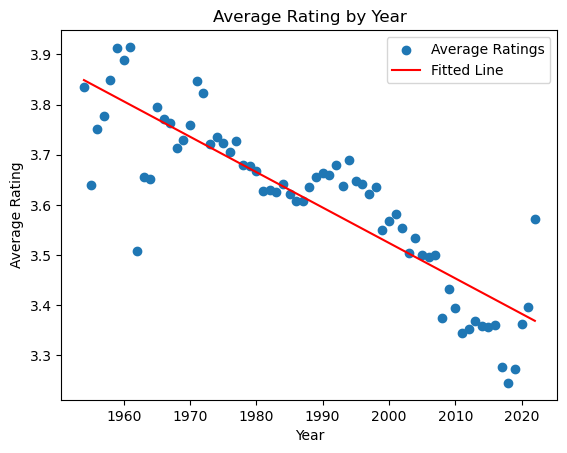

There is a statistically significant downward trend in the average ratings over the years (reject H0).


In [69]:
# Plotting the data and the regression line
plt.scatter(years, ratings, label='Average Ratings')
plt.plot(years, intercept + slope * years, 'r', label='Fitted Line')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.title('Average Rating by Year')
plt.legend()
plt.show()

# Conclusion based on p-value
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant downward trend in the average ratings over the years (reject H0).")
else:
    print("There is no statistically significant downward trend in the average ratings over the years (fail to reject H0).")

Based on the linear regression analysis, we found that the p-value is less than 0.05, indicating that the downward trend in average ratings over the years is statistically significant. Therefore, we conclude that there is statistically significant evidence suggesting that the average rating is indeed decreasing as time goes by.

### Question 5: Is there a significant association between the types of vocals (no vocals, male vocals, female vocals, both vocals) and the average rating quartiles of albums?

To do this, we first label the albums by the 4 rating quartiles. Then, we test for independence between these two variables -- vocal type and the average rating quartile.

$H_0$: There is no association between the type of vocals and the average rating quartiles of albums. In other words, the distribution of vocal types is independent of the rating quartiles.

$H_1$: There is an association between the type of vocals and the average rating quartiles of albums. In other words, the distribution of vocal types depends on the rating quartiles.

In [70]:
independence_df = df.copy()
vocal_list = ['no vocals', 'male vocals', 'female vocals', 'both vocals']
for vocals in vocal_list :
    vocal_encoding = pd.Series([0 for i in range(4999)])
    for i in range(4999) :
        if  independence_df['vocals'][i] == vocal_list.index(vocals) :
            vocal_encoding[i] = 1
    independence_df[vocals] = vocal_encoding

In [71]:
independence_df['rating_quartile'] = pd.qcut(independence_df['avg_rating'], 4, labels=["Q1", "Q2", "Q3", "Q4"])

melted_df = independence_df.melt(id_vars=['rating_quartile'], value_vars=['no vocals', 'male vocals', 'female vocals', 'both vocals'],
                    var_name='vocal_type', value_name='count')

melted_df = melted_df[melted_df['count'] == 1]
contingency_table = pd.crosstab(melted_df['rating_quartile'], melted_df['vocal_type'])

chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p)

# Check if the result is statistically significant
alpha = 0.05
if p < alpha:
    print("There is a statistically significant relationship between rating quartiles and vocalist types (they are not independent).")
else:
    print("There is no statistically significant relationship between rating quartiles and vocalist types (they are independent).")

Chi-Square Statistic: 131.53293642275742
Degrees of Freedom: 9
P-value: 5.737574994316297e-24
There is a statistically significant relationship between rating quartiles and vocalist types (they are not independent).


### Question 6: Which genres' mean `avg_rating`s are equal? Which genres' mean `avg_rating`s are not equal? 

In the dataset, each album has a list of specific genres that describe it. In order to compare across broader genres that everyone is familiar with, we group albums by whether their `genres` variable contains 'pop', 'rock', 'metal', 'jazz', 'hip hop', 'country', or 'ambient'.

To answer this question, we do multiple hypothesis testing where each pair of hypotheses are
$$
H_0: \mu_i = \mu_j \quad \text{vs} \quad H_a: \mu_i \neq \mu_j \quad \forall i \neq j
$$
where $\mu_i$ represents the mean `avg_rating` for the $i^{th}$ genre.

In order for our Type I error to stay equal to $\alpha = 0.1$, we apply Bonferroni Correction to our p-values. Below is the code that runs the multiple hypothesis testing.

In [72]:
genre_list = ['pop', 'rock', 'metal', 'jazz', 'hip hop', 'country', 'ambient']
alpha = 0.1
bonferroni_correction = alpha / math.comb(len(genre_list), 2)

completed_genre1_list = []
for genre1 in genre_list:
    index1 = []
    for i in range(4999):
        if genre1 in df['genres'][i]:
            index1.append(i)
    completed_genre1_list.append(genre1)
    for genre2 in genre_list :
        if genre2 not in completed_genre1_list :
            index2 = []
            for j in range(4999):
                if genre2 in df['genres'][j]:
                    index2.append(j)
            print(genre1, ' vs ', genre2)
            T, pvalue = stats.ttest_ind(
                df.iloc[index1]['avg_rating'], 
                df.iloc[index2]['avg_rating'], 
                equal_var=False,
                alternative='two-sided'
            )
            if pvalue < bonferroni_correction:
                print('Reject H0: Mean avg_rating of ', genre1, ' != ', genre2)
            else:
                print('Fail to reject H0: Mean avg_rating of ', genre1, ' = ', genre2)
            print()

pop  vs  rock
Reject H0: Mean avg_rating of  pop  !=  rock

pop  vs  metal
Reject H0: Mean avg_rating of  pop  !=  metal

pop  vs  jazz
Reject H0: Mean avg_rating of  pop  !=  jazz

pop  vs  hip hop
Fail to reject H0: Mean avg_rating of  pop  =  hip hop

pop  vs  country
Reject H0: Mean avg_rating of  pop  !=  country

pop  vs  ambient
Reject H0: Mean avg_rating of  pop  !=  ambient

rock  vs  metal
Fail to reject H0: Mean avg_rating of  rock  =  metal

rock  vs  jazz
Reject H0: Mean avg_rating of  rock  !=  jazz

rock  vs  hip hop
Fail to reject H0: Mean avg_rating of  rock  =  hip hop

rock  vs  country
Reject H0: Mean avg_rating of  rock  !=  country

rock  vs  ambient
Reject H0: Mean avg_rating of  rock  !=  ambient

metal  vs  jazz
Reject H0: Mean avg_rating of  metal  !=  jazz

metal  vs  hip hop
Reject H0: Mean avg_rating of  metal  !=  hip hop

metal  vs  country
Fail to reject H0: Mean avg_rating of  metal  =  country

metal  vs  ambient
Fail to reject H0: Mean avg_rating of  

**Conclusion**

We conclude that the pairs of genres whose *difference* in means of `avg_rating`s are **not** statistically significant are:
- pop and hip hop
- rock and metal
- rock and hip hop
- metal and country
- metal and ambient
- country and ambient

All other combinations of genres have significantly *different* means of `avg_ratings`.

In [77]:
# to verify that our conclusion is reasonable
for genre in genre_list:
    index = []
    for i in range(4999):
        if genre in df['genres'][i]:
            index.append(i)
    mean_avg_rating = df.iloc[index]['avg_rating'].mean()
    print('Mean avg_rating of ', genre,': ', mean_avg_rating)

Mean avg_rating of  pop :  3.3964006139677667
Mean avg_rating of  rock :  3.5351997950819674
Mean avg_rating of  metal :  3.5620161290322585
Mean avg_rating of  jazz :  3.7747311827956986
Mean avg_rating of  hip hop :  3.4676456876456876
Mean avg_rating of  country :  3.6442424242424245
Mean avg_rating of  ambient :  3.597006369426752


### Question 7: Which genres' mean `descriptors_sentiment`s are equal? Which genres' mean `descriptors_sentiment`s are not equal? 

To answer this question, we do multiple hypothesis testing where each pair of hypotheses are
$$
H_0: \mu_i = \mu_j \quad \text{vs} \quad H_a: \mu_i \neq \mu_j \quad \forall i \neq j
$$
where $\mu_i$ represents the mean `descriptors_sentiment` for the $i^{th}$ genre.

In order for our Type I error to stay equal to $\alpha = 0.1$, we apply Bonferroni Correction to our p-values. Below is the code that runs the multiple hypothesis testing.

In [76]:
completed_genre1_list = []
for genre1 in genre_list:
    index1 = []
    for i in range(4999):
        if genre1 in sentiment_df['genres'][i]:
            index1.append(i)
    completed_genre1_list.append(genre1)
    for genre2 in genre_list :
        if genre2 not in completed_genre1_list :
            index2 = []
            for j in range(4999):
                if genre2 in sentiment_df['genres'][j]:
                    index2.append(j)
            print(genre1, ' vs ', genre2)
            T, pvalue = stats.ttest_ind(
                sentiment_df.iloc[index1]['descriptors_sentiment'], 
                sentiment_df.iloc[index2]['descriptors_sentiment'], 
                equal_var=False,
                alternative='two-sided'
            )
            if pvalue < bonferroni_correction:
                print('Reject H0: Mean descriptors_sentiment of ', genre1, ' != ', genre2)
            else:
                print('Fail to reject H0: Mean descriptors_sentiment of ', genre1, ' = ', genre2)
            print()

pop  vs  rock
Reject H0: Mean descriptors_sentiment of  pop  !=  rock

pop  vs  metal
Reject H0: Mean descriptors_sentiment of  pop  !=  metal

pop  vs  jazz
Fail to reject H0: Mean descriptors_sentiment of  pop  =  jazz

pop  vs  hip hop
Reject H0: Mean descriptors_sentiment of  pop  !=  hip hop

pop  vs  country
Fail to reject H0: Mean descriptors_sentiment of  pop  =  country

pop  vs  ambient
Reject H0: Mean descriptors_sentiment of  pop  !=  ambient

rock  vs  metal
Reject H0: Mean descriptors_sentiment of  rock  !=  metal

rock  vs  jazz
Reject H0: Mean descriptors_sentiment of  rock  !=  jazz

rock  vs  hip hop
Reject H0: Mean descriptors_sentiment of  rock  !=  hip hop

rock  vs  country
Fail to reject H0: Mean descriptors_sentiment of  rock  =  country

rock  vs  ambient
Reject H0: Mean descriptors_sentiment of  rock  !=  ambient

metal  vs  jazz
Reject H0: Mean descriptors_sentiment of  metal  !=  jazz

metal  vs  hip hop
Fail to reject H0: Mean descriptors_sentiment of  meta

**Conclusion**

We conclude that the pairs of genres whose *difference* in means of `descriptors_sentiment`s are **not** statistically significant are:
- pop and jazz
- pop and country
- rock and country
- metal and hip hop
- jazz and country
- country and ambient

All other combinations of genres have significantly *different* means of `descriptors_sentiment`.

In [79]:
# to verify that our conclusion is reasonable
for genre in genre_list:
    index = []
    for i in range(4999):
        if genre in sentiment_df['genres'][i]:
            index.append(i)
    mean_sentiment_value = sentiment_df.iloc[index]['descriptors_sentiment'].mean()
    print('Mean descriptors_sentiment of ', genre,': ', mean_sentiment_value)

Mean descriptors_sentiment of  pop :  0.4103303146584804
Mean descriptors_sentiment of  rock :  0.25301019467213115
Mean descriptors_sentiment of  metal :  -0.14893924731182795
Mean descriptors_sentiment of  jazz :  0.3547360215053763
Mean descriptors_sentiment of  hip hop :  -0.0911104895104895
Mean descriptors_sentiment of  country :  0.26454242424242425
Mean descriptors_sentiment of  ambient :  0.059457324840764325


### Question 8: Which ranges of sentiment values have equal mean `avg_rating`s? Which ranges of sentiment values have different mean `avg_rating`s?

Each album in the dataset has been assigned a `descriptors_sentiment` value between -1 and 1. To answer this question, we organize the albums as 
- $-1 \leq$ `descriptors_sentiment` $< -0.7 \longrightarrow$ 'strongly negative'
- $-0.7 \leq$ `descriptors_sentiment` $< -0.4 \longrightarrow$ 'moderately negative'
- $-0.4 \leq$ `descriptors_sentiment` $< -0.1 \longrightarrow$ 'slightly negative'
- $-0.1 \leq$ `descriptors_sentiment` $< 0.1 \longrightarrow$ 'neutral'
- $0.1 \leq$ `descriptors_sentiment` $< 0.4 \longrightarrow$ 'slightly positive'
- $0.4 \leq$ `descriptors_sentiment` $< 0.7 \longrightarrow$ 'moderately positive'
- $0.7 \leq$ `descriptors_sentiment` $< 1 \longrightarrow$ 'strongly positive'

To answer this question, we do multiple hypothesis testing where each pair of hypotheses are
$$
H_0: \mu_i = \mu_j \quad \text{vs} \quad H_a: \mu_i \neq \mu_j \quad \forall i \neq j
$$
where $\mu_i$ represents the mean `avg_rating` for the $i^{th}$ sentiment value range.

In order for our Type I error to stay equal to $\alpha = 0.1$, we apply Bonferroni Correction to our p-values. Below is the code that runs the multiple hypothesis testing.

In [74]:
sentiment_list = ['strongly_negative', 'moderately_negative', 'slightly_negative', 'neutral', 'slightly_positive', 'moderately_positive', 'strongly_positive']
values_list = [-1, -0.7, -0.4, -0.1, 0.1, 0.4, 0.7, 1]

alpha = 0.1
bonferroni_correction = alpha / math.comb(len(sentiment_list), 2)

for i in range(len(sentiment_list)) :
    sentiment_range_1 = df[ (values_list[i] <= df.descriptors_sentiment) &  (df.descriptors_sentiment < values_list[i+1]) ]
    for j in range(i+1, len(sentiment_list)) :
        sentiment_range_2 = df[ (values_list[j] <= df.descriptors_sentiment) & (df.descriptors_sentiment < values_list[j+1]) ]
        print(sentiment_list[i], ' vs ', sentiment_list[j])
        T, pvalue = stats.ttest_ind(
                sentiment_range_1['avg_rating'], 
                sentiment_range_2['avg_rating'], 
                equal_var=False,
                alternative='two-sided'
            )
        if pvalue < bonferroni_correction:
            print('Reject H0: Mean avg_rating of ', sentiment_list[i], ' != ', sentiment_list[j])
        else:
            print('Fail to reject H0: Mean avg_rating of ', sentiment_list[i], ' = ', sentiment_list[j])
        print()

strongly_negative  vs  moderately_negative
Fail to reject H0: Mean avg_rating of  strongly_negative  =  moderately_negative

strongly_negative  vs  slightly_negative
Fail to reject H0: Mean avg_rating of  strongly_negative  =  slightly_negative

strongly_negative  vs  neutral
Fail to reject H0: Mean avg_rating of  strongly_negative  =  neutral

strongly_negative  vs  slightly_positive
Fail to reject H0: Mean avg_rating of  strongly_negative  =  slightly_positive

strongly_negative  vs  moderately_positive
Fail to reject H0: Mean avg_rating of  strongly_negative  =  moderately_positive

strongly_negative  vs  strongly_positive
Fail to reject H0: Mean avg_rating of  strongly_negative  =  strongly_positive

moderately_negative  vs  slightly_negative
Fail to reject H0: Mean avg_rating of  moderately_negative  =  slightly_negative

moderately_negative  vs  neutral
Fail to reject H0: Mean avg_rating of  moderately_negative  =  neutral

moderately_negative  vs  slightly_positive
Fail to rejec

**Conclusion**

We conclude that the pairs of sentiment value ranges whose *difference* in means of `avg_rating`s are statistically significant are:
- moderately negative and strongly positive
- neutral and strongly positive

All other combinations of sentiment value ranges do **not** have significantly *different* means of `avg_ratings`.

In [75]:
# to verify our conclusion is reasonable

for i in range(len(sentiment_list)) :
    sentiment_range = df[ (values_list[i] <= df.descriptors_sentiment) &  (df.descriptors_sentiment < values_list[i+1]) ]
    mean_avg_rating = sentiment_range.avg_rating.mean()
    print('Mean avg_rating of ', sentiment_list[i], ': ', mean_avg_rating)

Mean avg_rating of  strongly_negative :  3.5580672268907567
Mean avg_rating of  moderately_negative :  3.5645375218150086
Mean avg_rating of  slightly_negative :  3.5575638506876226
Mean avg_rating of  neutral :  3.573721881390593
Mean avg_rating of  slightly_positive :  3.5300332778702166
Mean avg_rating of  moderately_positive :  3.541908163265306
Mean avg_rating of  strongly_positive :  3.504632587859425


## Predictive Modeling

Predictive modeling on `avg_rating` is essential for understanding and forecasting the factors that influence album ratings. By analyzing patterns and relationships between various features (such as vocal type, genre, release year, and others) and average ratings, we can gain valuable insights into what makes an album more or less likely to receive high ratings. This can help music producers, artists, and marketers make informed decisions about future projects, tailor their strategies to audience preferences, and improve the overall quality and appeal of their music. Additionally, predictive models can assist streaming platforms in recommending albums that align with users’ tastes, enhancing user satisfaction and engagement.

#### Data Investigation and Preprocessing

__One-Hot Encoding of Genre and Vocalist Type__

One-hot encoding is a process used to convert categorical data variables so they can be provided to machine learning algorithms to improve predictions. In this script, we perform one-hot encoding for two features: genre and vocalist type.

1. __Genre Encoding__:
We encode several music genres including 'pop', 'rock', 'metal', 'jazz', 'hip hop', 'country', and 'ambient'. For each genre, a new column is created in the DataFrame
- Each row in these columns contains a `1` if that genre is present in the `genres` column of the DataFrame for that row, and a `0` otherwise.

2. __Vocalist Type Encoding__:
Vocalist types are categorized into 'no vocals', 'male vocals', 'female vocals', and 'both vocals'. Each type is encoded similarly to genres:
- A new column is created for each vocalist type.
- The column for a particular vocalist type contains a `1` if that type matches the index of the type in the `vocals` column, and a `0` otherwise.

3. __Avoiding Multicollinearity__:
To avoid multicollinearity, which can complicate the interpretation of the model's output, we exclude the 'no vocals' category from our features after encoding:
- The 'no vocals' column is dropped from the DataFrame since if an album does not fall into any of the other vocalist categories, it can be inferred that it has no vocals.

In [282]:
encoded_df = df.copy()

for genre in ['pop', 'rock', 'metal', 'jazz', 'hip hop', 'country', 'ambient'] :
    genre_encoding = pd.Series([0 for i in range(4999)])
    for i in range(4999) :
        if genre in df['genres'][i] :
            genre_encoding[i] = 1
    encoded_df[genre] = genre_encoding

vocal_list = ['no vocals', 'male vocals', 'female vocals', 'both vocals']
for vocals in vocal_list :
    vocal_encoding = pd.Series([0 for i in range(4999)])
    for i in range(4999) :
        if  encoded_df['vocals'][i] == vocal_list.index(vocals) :
            vocal_encoding[i] = 1
    encoded_df[vocals] = vocal_encoding

encoded_df = encoded_df.drop(['vocals', 'no vocals'], axis=1)

In [283]:
encoded_df.columns = [i if ' ' not in i else i.replace(' ','_') for i in encoded_df.columns ]

In [284]:
encoded_df.head()

,position,release_name,artist_name,year,genres,descriptors,avg_rating,rating_count,review_count,genres_sentiment,...,pop,rock,metal,jazz,hip_hop,country,ambient,male_vocals,female_vocals,both_vocals
0,1,OK Computer,Radiohead,1997,alternative rock art rock,melancholic anxious futuristic malevocals exis...,4.24,74027,1541,0.0,...,0,1,0,0,0,0,0,1,0,0
1,2,Kid A,Radiohead,2000,art rock experimental rock electronic,cold melancholic futuristic anxious atmospheri...,4.23,61658,751,0.0,...,0,1,0,0,0,0,0,1,0,0
2,3,The Dark Side of the Moon,Pink Floyd,1973,art rock progressive rock,philosophical atmospheric introspective existe...,4.21,60192,1557,0.0,...,0,1,0,0,0,0,0,1,0,0
3,4,Loveless,My Bloody Valentine,1991,shoegaze noise pop,noisy ethereal atmospheric romantic love dense...,4.24,53174,1264,0.0,...,1,0,0,0,0,0,0,0,1,0
4,5,My Beautiful Dark Twisted Fantasy,Kanye West,2010,pop rap hip hop,epic boastful passionate sampling hedonistic v...,4.09,52149,638,0.0,...,1,0,0,0,1,0,0,1,0,0


__Correlation matrix__

To understand the relationships and potential multicollinearity between various features in our dataset, a correlation matrix is computed and visualized. This matrix helps in identifying how different variables are related to one another and to the target variable `avg_rating`.

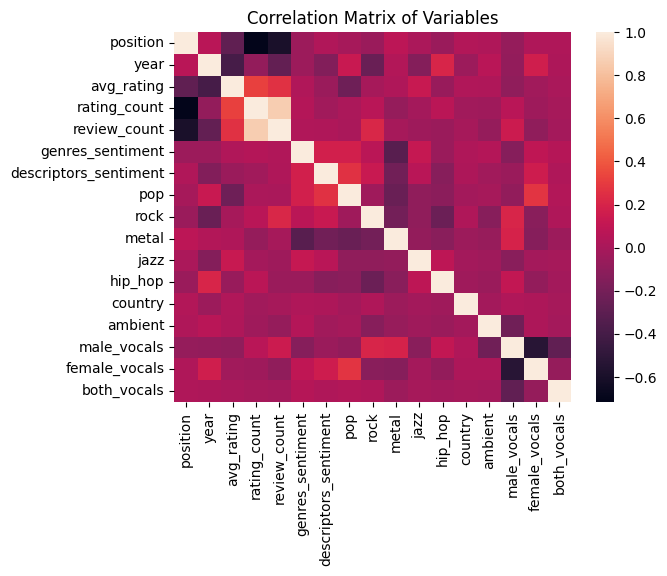

In [285]:
sns.heatmap(encoded_df.corr(), annot=False)
plt.title('Correlation Matrix of Variables')
plt.show()

By looking at the above correlation matrix, it seems that `rating_count` and `review_count` are highly correlated. This may introduce the problem of multicollinearity in our regression model. To fix this, we will drop the `review_count`.

In [286]:
regression_df = encoded_df.drop(columns=['review_count'])

__Train Test Split__

Then, we split the data into training and testing set by the proportion of 8:2. From now on, our models will be fitted on the training set and be evaluated on the testing set.

In [287]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [288]:
regression_df.drop(['release_name', 'artist_name', 'genres', 'descriptors'],axis=1, inplace=True)

In [289]:
train_data, test_data = train_test_split(regression_df, test_size=0.2, random_state=42, shuffle=True)

#### Baseline Linear Regression

For the baseline model, we decide to only include `year`, `rating_count`, `genre_sentiment` and `descriptor_sentiment`, and investigate these variates' effects on the response variable `avg_rating`.

In [290]:
import statsmodels.formula.api as smf

$$H_0: \text{All coefficients (excluding the intercept) are equal to zero, i.e. } \beta_1 = \beta_2 = \beta_3 = \beta_4 = 0$$
$$H_a: \text{At least one of the coefficients (excluding the intercept) is non-zero, i.e. } \beta_j \neq 0 \quad \text{for at least one } j$$

In [291]:
response = 'avg_rating'

In [292]:
baseline_formula = f'{response} ~ year + rating_count + genres_sentiment + descriptors_sentiment'
baseline_model = smf.ols(baseline_formula, data=train_data).fit()

In [293]:
print(baseline_model.summary())

                            OLS Regression Results                            
Dep. Variable:             avg_rating   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     326.8
Date:                Thu, 06 Jun 2024   Prob (F-statistic):          1.36e-243
Time:                        14:03:51   Log-Likelihood:                -1139.9
No. Observations:                3999   AIC:                             2290.
Df Residuals:                    3994   BIC:                             2321.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                20.72

The insights extracted from the baseline model summary:

1. R-squared (0.247): This value indicates that approximately 24.7% of the variability in average ratings is explained by the model. This isn’t particularly high, suggesting the model captures some, but not all, factors influencing ratings.
2. Coefficients:
    - `year` (-0.0087): This coefficient is negative, indicating that as the year increases, the average rating slightly decreases, holding all else constant. Its p-value (< 0.0001) suggests this is statistically significant. This matches our previous findings of decreasing ratings as time goes by.
    - `rating_count` (0.00001803): Positive coefficient, statistically significant, indicating a slight increase in average rating with an increase in rating count.
    - `genres_sentiment` (0.0362): Not statistically significant (p-value = 0.352), meaning changes in genre sentiment don’t reliably predict changes in average rating in this dataset.
    - `descriptors_sentiment` (-0.0713): This is significant and negative, suggesting that more negative sentiment in descriptors correlates with lower ratings.
3. F-statistic: The model is statistically significant as a whole, with a very low probability (near zero) that the observed results are due to chance.
4. Durbin-Watson (1.999): This value, close to 2, suggests that there is no serious autocorrelation in the residuals.

Based on the F-statistic and its p-value, we conclude that there is compelling evidence to conclude that the predictors in the model collectively have a significant effect on the dependent variable, `avg_rating`.

#### Comparison of Models

In this part, we are interested in whether adding more predictors will improve the model fit. Specifically, we will compare the baseline model to the full model containing all covariates except for `review_count`.

$$H_0: \text{The reduced model is adequate, and the additional predictors in the full model do not provide a significantly better fit to the data.}$$
$$H_a: \text{The full model, with the additional predictors, provides a significantly better fit than the reduced model.}$$

In [294]:
covar_formula = response + ' ~ ' + ' + '.join(pred for pred in train_data.columns if pred != response)
covar_formula

'avg_rating ~ position + year + rating_count + genres_sentiment + descriptors_sentiment + pop + rock + metal + jazz + hip_hop + country + ambient + male_vocals + female_vocals + both_vocals'

In [295]:
covar_model = smf.ols(covar_formula,data=train_data).fit()

In [296]:
anova_table = sm.stats.anova_lm(baseline_model,covar_model)
print(anova_table)

   df_resid         ssr  df_diff    ss_diff          F        Pr(>F)
0    3994.0  414.066198      0.0        NaN        NaN           NaN
1    3983.0  375.396415     11.0  38.669784  37.299176  5.113282e-77


- Degrees of Freedom (df_resid and df_diff): The full model has 11 more parameters (predictors) than the baseline model, as indicated by df_diff = 11.
- Sum of Squares (ssr and ss_diff): The sum of squared residuals decreases from 414.07 in the baseline model to 375.40 in the full model. The difference in sum of squares (ss_diff) is 38.67, indicating an improvement in fit by the full model.
- F-statistic (F): The F-statistic is 37.30. This statistic is used to compare the two models. Higher values generally indicate a more significant difference in model fits.
- p-value (Pr(>F)): The p-value is extremely small (5.11e-77), which is much less than the typical significance level of 0.05.

Since the p-value is very small, we __reject__ the null hypothesis that the additional predictors do not improve the model. This indicates that adding the extra predictors significantly improves the model fit.

We can confirm our conclusion by comparing the models' performance on the training and testing sets. Specifically, we use mean squared error (MSE) as our evaluation metric.

In [297]:
X_train, y_train = train_data.drop(['avg_rating'],axis=1), train_data['avg_rating']
X_test, y_test = test_data.drop(['avg_rating'],axis=1), test_data['avg_rating']

In [298]:
baseline_train_pred = baseline_model.predict(X_train)
baseline_test_pred = baseline_model.predict(X_test)
full_train_pred = covar_model.predict(X_train)
full_test_pred = covar_model.predict(X_test)

In [299]:
print("Baseline MSE on training set: " + str(round(mean_squared_error(baseline_train_pred, y_train),5)))
print("Full MSE on training set: " + str(round(mean_squared_error(full_train_pred, y_train),5)))

Baseline MSE on training set: 0.10354
Full MSE on training set: 0.09387


In [300]:
print("Baseline MSE on testing set: " + str(round(mean_squared_error(baseline_test_pred, y_test),5)))
print("Full MSE on testing set: " + str(round(mean_squared_error(full_test_pred, y_test),5)))

Baseline MSE on testing set: 0.11048
Full MSE on testing set: 0.09802


In [302]:
mse_data = {
    "Baseline": {"Training": 0.10354, "Testing": 0.11048},
    "Full Model": {"Training": 0.09387, "Testing": 0.09802}
}

mse_df = pd.DataFrame(mse_data).T.reset_index()
mse_df = mse_df.melt(id_vars="index", var_name="Set", value_name="MSE")
mse_df.rename(columns={"index": "Model"}, inplace=True)
mse_df

,Model,Set,MSE
0,Baseline,Training,0.10354
1,Full Model,Training,0.09387
2,Baseline,Testing,0.11048
3,Full Model,Testing,0.09802


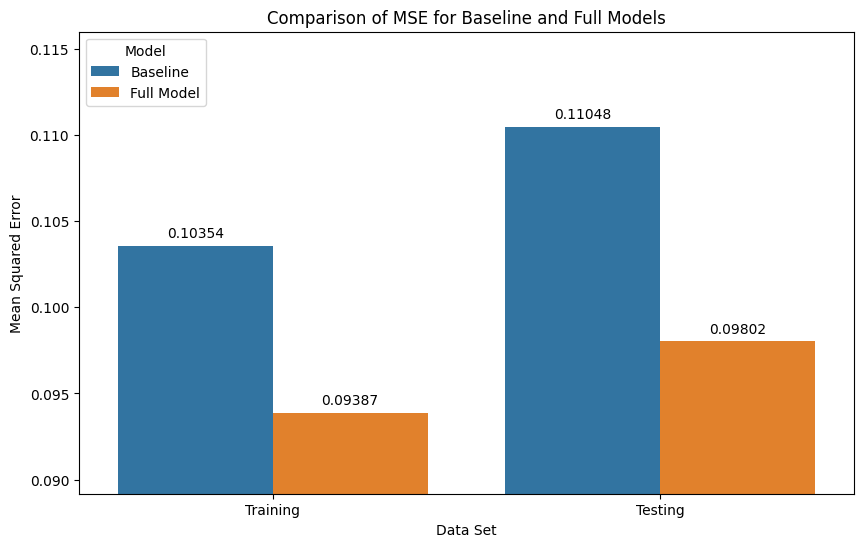

In [307]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume mse_df is your DataFrame containing the MSE data
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=mse_df, x='Set', y='MSE', hue='Model')
plt.title('Comparison of MSE for Baseline and Full Models')
plt.xlabel('Data Set')
plt.ylabel('Mean Squared Error')
plt.legend(title='Model', loc='upper left')  # Move legend to upper left

# Set a floor for the y-axis to better visualize the bars
plt.ylim(bottom=min(mse_df['MSE']) * 0.95)  # 5% below the smallest MSE for aesthetics

# Enhance the visualization with values on bars
for p in barplot.patches:
    height = p.get_height()
    if height > 0:  # Only annotate if height is greater than 0
        barplot.annotate(format(height, '.5f'), 
                         (p.get_x() + p.get_width() / 2., height), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

plt.show()

- Baseline MSE on training set: 0.10354
- Full MSE on training set: 0.09387

The full model has a lower MSE on the training set, indicating a better fit to the training data.

- Baseline MSE on testing set: 0.11048
- Full MSE on testing set: 0.09802

The full model also has a lower MSE on the testing set, suggesting that it generalizes better to unseen data compared to the baseline model.


## Discussion

A few limitations to our project arise as a result of the dataset we used. The creation of the Spotify app was in the year 2006<a name="cite_ref1"></a>[<sup>1</sup>](#ref1) and data collection of specific stats during that time wasn't as accurate/extensive as it is today. In other words, we aren't able to gather the diverse set of reviews and sentiments on specific albums, due to the fact that some may have been created prior to the app's creation, as there is a lack of resources available for calculation during that period. As a result, our analysis of sentiment and rating calculation may not be as extensive and thus can hinder our overall results. 

Another limitation which can arise is through the use of the Sentiment Intensity Analyzer from the VADER library. Sentiment analysis is defined as "the process of ‘computationally’ determining whether a piece of writing is positive, negative or neutral."<a name="cite_ref2"></a>[<sup>2</sup>](#ref2) Because we determine our compound scores for the genre and descriptors through the analyzer, there is a possibility that the analyzer itself doesn't have much information to base it's scores on as some pieces of text may be too short or the order in which the descriptors are placed may have a confounding effect on the overall compound score. 

Additionally, our dataset is based on the data collected by the site RateYourMusic.com<a name="cite_ref3"></a>[<sup>3</sup>](#ref3) meaning that although we do have a multitude of reviews from a certain population, the results may not be representative for a much larger group of people. We are able to conduct our analysis but there is a chance that the albums themselves are rated differently according to other sources as well. 

In the future, we would like to be able to build upon our study and conduct our analysis with better datasets that cover a larger range of albums and music review platforms. Although we were able to come to significant conclusions through our multiple hypothesis tests in the end, the data itself may not be very representative of the sentiments of a larger population outside scope.

In conclusion, there are many aspects of this study that can be improved/worked on from the datasets utilized to the choices of what we used to measure the sentiments of various albums as well. Overall, there is a lot that can be studied from the music industry and while we have shown significant findings in our predictive modeling and testing, we can take a step back and appreciate the diversity of albums in this day and age. By doing so, we can gain a better understanding of the dynamics music plays in the world around us and learn about the diversity of opinion within our communities.

1. <a name="ref1"></a> [^](#cite_ref1) https://en.wikipedia.org/wiki/Spotify
2. <a name="ref2"></a> [^](#cite_ref2) https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
3. <a name="ref3"></a> [^](#cite_ref3) https://www.kaggle.com/datasets/tobennao/rym-top-5000/data?select=rym_clean1.csv